# Load Package

In [3]:
#待續
#stratify  = Y，測試一下模型結果 
#==>無法找到錯誤

#2、請泰竹和游達確認一下目標函數是總誤差還是平均誤差。 
#>平均 

#3、請泰竹和游達增加Training Sample Size，因為我過去都是按照T. Masters的建議，Sample Size = number of weights x 2。我記得游達的FNN大約有100個權重，32個samples直覺上沒有達到學習的效果。
#>無改善

#4、建議從1層Hidden Layer，Hidden nodes = Sqrt(Input nodes x Output nodes)開始，慢慢擴大結構。上述網路課程對直接採用多層Hidden Layers的方式很保留(這跟我以前的經驗一樣)，可否請周平寄給我一些建議使用多層Hidden Layers的論文。
#https://www.youtube.com/watch?v=5dWp1mw_XNk&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0&index=40  

#改變結構，Hidden=2，nodes從3~5開始，增加一個增加一個，看看會不會改善
#找找看哪一個變數拿掉，對結果差最多

In [4]:
#https://github.com/YuTaNCCU/201902_ANN_Metaheuristic/tree/master/ES
import random
import pandas as pd
from string import ascii_lowercase
from copy import deepcopy
from abc import ABCMeta, abstractmethod
from copy import deepcopy
from collections import deque
from numpy import argmax
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential 
from keras.callbacks import TensorBoard,EarlyStopping
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
import  seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Load Data

In [5]:
url = 'https://raw.githubusercontent.com/YuTaNCCU/201902_ANN_Metaheuristic/master/Data/red.csv'
red = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/YuTaNCCU/201902_ANN_Metaheuristic/master/Data/white.csv'
white = pd.read_csv(url)

red['WineCatg']='red'
white['WineCatg']='white'
Wine_Data = pd.concat([red, white]).reset_index(drop=True)

display(
    red.shape,
  white.shape,
  Wine_Data.shape,
  Wine_Data.head(5),
  Wine_Data.tail(5)
)

(1599, 13)

(4898, 13)

(6497, 13)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,WineCatg
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,WineCatg
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white
6496,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,white


In [6]:
#scale
from sklearn import preprocessing
Wine_Data_preprocessed = Wine_Data.drop(['WineCatg'], axis=1)
scaler = preprocessing.StandardScaler() 
col = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',  'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Wine_Data_preprocessed[col] = scaler.fit_transform(Wine_Data_preprocessed[col])
Wine_Data_preprocessed.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446446,1.034993,1.813090,0.193097,-0.915464,5
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862605,0.701486,-0.115073,0.999579,-0.580068,5
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092603,0.768188,0.258120,0.797958,-0.580068,5
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986450,1.101694,-0.363868,0.327510,-0.580068,6
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446446,1.034993,1.813090,0.193097,-0.915464,5


In [7]:
print( '原本各種quality記數: \n', Wine_Data.quality.value_counts().sort_index() )
Wine_Data_Y01 = Wine_Data_preprocessed.replace({'quality':[3,4,5,6,7,8,9]},{'quality':[0,0,0,1,1,1,1]})
print( '分類成好壞兩種quality記數: \n', Wine_Data_Y01.quality.value_counts().sort_index() )
Wine_Data_Y01.head(5)

原本各種quality記數: 
 3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64
分類成好壞兩種quality記數: 
 0    2384
1    4113
Name: quality, dtype: int64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446446,1.034993,1.813090,0.193097,-0.915464,0
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862605,0.701486,-0.115073,0.999579,-0.580068,0
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092603,0.768188,0.258120,0.797958,-0.580068,0
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986450,1.101694,-0.363868,0.327510,-0.580068,1
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446446,1.034993,1.813090,0.193097,-0.915464,0


In [8]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X=Wine_Data_Y01.drop(['quality'], axis=1)
y=Wine_Data_Y01['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle =True, random_state= 123, )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle =True, random_state= 123)

display(
      X_train.mean(),
      X_val.mean(),
      X_test.mean(),
      y_train.mean(),
      y_val.mean(),
      y_test.mean(),
)
display(
      X_train.shape,
      X_val.shape,
      X_test.shape,
      y_train.shape,
      y_val.shape,
      y_test.shape,
)
display(y_train.value_counts(),
y_val.value_counts(),
y_test.value_counts())

fixed acidity           0.004930
volatile acidity       -0.010341
citric acid             0.011823
residual sugar          0.012948
chlorides               0.001430
free sulfur dioxide     0.017502
total sulfur dioxide    0.011293
density                 0.008075
pH                     -0.001852
sulphates              -0.006745
alcohol                -0.004831
dtype: float64

fixed acidity          -0.018892
volatile acidity       -0.002264
citric acid             0.002260
residual sugar         -0.043104
chlorides              -0.006566
free sulfur dioxide    -0.010555
total sulfur dioxide   -0.007419
density                -0.043976
pH                     -0.011369
sulphates              -0.013306
alcohol                 0.025738
dtype: float64

fixed acidity          -0.000652
volatile acidity        0.034878
citric acid            -0.039615
residual sugar         -0.006921
chlorides               0.000680
free sulfur dioxide    -0.047521
total sulfur dioxide   -0.030222
density                 0.009359
pH                      0.015018
sulphates               0.032214
alcohol                -0.005143
dtype: float64

0.6331489054606687

0.6240384615384615

0.64

(4157, 11)

(1040, 11)

(1300, 11)

(4157,)

(1040,)

(1300,)

1    2632
0    1525
Name: quality, dtype: int64

1    649
0    391
Name: quality, dtype: int64

1    832
0    468
Name: quality, dtype: int64

In [9]:
# Splitting the dataset into the Training set and Test set 
# stratify 未完成，訓練模型時會有錯誤發生
"""from sklearn.model_selection import train_test_split
X=Wine_Data_Y01.drop(['quality'], axis=1)
y=Wine_Data_Y01['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle =True, random_state= 1234, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle =True, random_state= 1234, stratify=y_train)

display(
      X_train.mean(),
      X_val.mean(),
      X_test.mean(),
      y_train.mean(),
      y_val.mean(),
      y_test.mean(),
)
display(
      X_train.shape,
      X_val.shape,
      X_test.shape,
      y_train.shape,
      y_val.shape,
      y_test.shape,
)
display(y_train.value_counts(),
y_val.value_counts(),
y_test.value_counts())"""

"from sklearn.model_selection import train_test_split\nX=Wine_Data_Y01.drop(['quality'], axis=1)\ny=Wine_Data_Y01['quality']\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle =True, random_state= 1234, stratify=y)\nX_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle =True, random_state= 1234, stratify=y_train)\n\ndisplay(\n      X_train.mean(),\n      X_val.mean(),\n      X_test.mean(),\n      y_train.mean(),\n      y_val.mean(),\n      y_test.mean(),\n)\ndisplay(\n      X_train.shape,\n      X_val.shape,\n      X_test.shape,\n      y_train.shape,\n      y_val.shape,\n      y_test.shape,\n)\ndisplay(y_train.value_counts(),\ny_val.value_counts(),\ny_test.value_counts())"

# Define Performance

In [29]:
def Performance(model):
    #######################
    ## Confusion Matrix  ##
    #######################

    # Predicting the Test set results
    y_score = model.predict(X_test) #X_train X_test
    y_pred = (y_score > 0.5)  #y_pred 有 NA

    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred) #y_train y_test
    #######################
    ###    accuracy      ##
    #######################
    acc = round(((cm[0][0] + cm[1][1])/sum(sum(cm)))*100,2)
    print("Our accuracy is {}%".format(acc))

    sns.heatmap(cm,annot=True)
    #######################
    ###       AUC        ##
    #######################    
    from sklearn.metrics import roc_auc_score
    AUC=round((roc_auc_score(y_test, y_score)*100),2)
    print("Our AUC is {}%".format(AUC))
    
    #######################
    ###    ROC curve     ##
    #######################
    import numpy as np
    import matplotlib.pyplot as plt
    from itertools import cycle

    from sklearn import svm, datasets
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    from scipy import interp
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes =2
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #Plot of a ROC curve for a specific class
    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show() 
    
    return acc, AUC

# Define Keras Model

In [27]:
def SummarizeHistory(modelcallbacks, prfix='', UseValid=False) :
    
    plt.figure()
    plt.plot(modelcallbacks.history[prfix+'loss'])  #loss mean_absolute_error 
    if UseValid==True:
        plt.plot(modelcallbacks.history['val_'+prfix+'loss'])  #val_loss 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.show()

    plt.figure()
    plt.plot(modelcallbacks.history[prfix+'acc'])  #loss mean_absolute_error 
    if UseValid==True:
        plt.plot(modelcallbacks.history['val_'+prfix+'acc'])  # val_mean_absolute_error
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()
    
def ModelCompile(node=round(X_train.shape[1]/4)):
    from keras import backend as K
    from keras.layers import Dense
    from keras.models import Sequential, Model as keras_models_Model

    K.clear_session() 
    gpu_options = tf.GPUOptions(allow_growth=True)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    tf.keras.backend.set_session(sess)

    model = Sequential()
    #model.add(Dense(round(X_train.shape[1]*4), activation='relu', input_shape=(X_train.shape[1],)))
    #model.add(Dense(round(X_train.shape[1]*3), activation='relu'))
    #model.add(Dense(round(X_train.shape[1]*2), activation='relu'))
    model.add(Dense(node, activation='relu', name = 'IntermediateLayer', input_shape=(X_train.shape[1],)))
    """model.add(Dense(round(X_train.shape[1]/2), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(round(X_train.shape[1]/4), activation='relu'))
    model.add(Dense(round(X_train.shape[1]/4), activation='relu', name = 'IntermediateLayer'))"""
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def ModelFit(model, weights, epochs):
    #class_weight = {0: 1., 1: 1525/2632}
    model.set_weights(weights)
    modelcallbacks = model.fit(X_train, y_train, epochs=epochs, batch_size=200, verbose=0,
        validation_data = (X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=2, restore_best_weights=True)],
        shuffle=True) #, class_weight=class_weight
    SummarizeHistory(modelcallbacks, UseValid=True)                                        
    weights = model.get_weights() 
    return model, weights

# Define ES Class 

In [12]:
class ES:
    """
    Conducts tabu search
    """
    __metaclass__ = ABCMeta

    #default hyper parameters
    InitialSigma = None
    ParentsSize = None
    ChildSize = None
    tao = None
    
    #for input/output
    KerasModels = None
    WeightsStrucure = None   
    weights = None
    
    #for record
    cur_steps = 1
    best_weight = None
    best_score = None
    best_Acc = None
    
    UseOLSReg=None
    X_train=None
    y_train=None
    
    def __init__(self, KerasModels, X_train, y_train, UseOLSReg=False, InitialSigma = 0.1, ParentsSize = 15, ChildSize = 100, tao = 0.5):
        """
        :param KerasModels: a Keras model, like keras.engine.sequential.Sequential
        :param weights: initial weights, should be a Keras model weight
        :param max_steps: maximum number of steps to run algorithm for
        :param UseOLSReg: If True, than use "OLS Regression" for the last layer
        
        """
        self.KerasModels = KerasModels
        
        self.UseOLSReg = UseOLSReg
        
        self.X_train=X_train
        self.y_train=y_train
 
        if all(isinstance(x, float) for x in [InitialSigma, tao]) and all(x > 0 for x in [InitialSigma, tao]):
            self.InitialSigma = InitialSigma
            self.tao = tao
        else:
            raise TypeError('InitialSigma & tao must be a positive float')
            
        if all(isinstance(x, int) for x in [ParentsSize, ChildSize]) and all(x > 0 for x in [ParentsSize, ChildSize]):
            self.ParentsSize = ParentsSize
            self.ChildSize = ChildSize
        else:
            raise TypeError('ParentsSize, ChildSize & max_steps must be a positive integer')

    def __str__(self): 
        return ('ES STEPS: %d ' +
                ' - BEST Accuracy: %.4f '+
                ' - BEST Score(Log Loss): %.4f ') % \
               (self.cur_steps, self.best_Acc, self.best_score)

    def __repr__(self):
        return self.__str__() 
    
    def _FlattenWeights(self, weights):
        """
        flatten weights
        
        param weights: keras神經網路的權重格式:nparray包在list中
        return WeightsStrucure : 神經網路各層的權重shape包在list中，unflatten時會用到
        return FlattenedWeights : 一維list包含所有的權重
        """
        WeightsStrucure = []
        FlattenedWeights = []
        for i_layer in weights:
            WeightsStrucure.append(i_layer.shape)
            if len(i_layer.shape) == 1 :# 該層權重的shape為一維 e.g. (15,)      
                FlattenedWeights.extend(i_layer)
            else :# 該層權重的shape為二維 e.g. (30, 15)  
                for i_links in i_layer:
                    FlattenedWeights.extend(i_links)
        return WeightsStrucure, FlattenedWeights

    def _UnflattenWeights(self, WeightsStrucure, ModifiedWeights):
        """
        Unflatten(回復成原本的結構) weights  
        
        param WeightsStrucure : 神經網路各層的權重shape包在list中
        param ModifiedWeights : 一維list包含所有meteHeuristic修改過的權重
        return: keras神經網路的權重格式:nparray包在list中
        """
        UnflattenWeights = []
        i_index = 0 
        for i_layer in WeightsStrucure:
            if len(i_layer) == 1 : # 該層權重的shape為一維 e.g. (15,)      
                TempList = ModifiedWeights[i_index:(i_index + i_layer[0])]
                TempList = np.asarray(TempList)
                i_index = i_index + i_layer[0]
            else : # 該層權重的shape為二維 e.g. (30, 15)  
                TempList = ModifiedWeights[i_index:(i_index + (i_layer[0]*i_layer[1]))]
                TempList = np.reshape(TempList, i_layer )
                i_index = i_index + (i_layer[0]*i_layer[1])
            UnflattenWeights.append(TempList)
        return UnflattenWeights   
    
    def _best(self, Population_Child_score):
        """
        Finds the best member of a neighborhood
        :param Population_Child_score: a np array
        :return: the indtex of N best member, N = ParentsSize
        """
        return np.array( Population_Child_score ).argsort()#[::-1]
    
    def _Recombination(self, Population_Parents_Weights, Population_Parents_Sigma, rows): #GenerateParents
        """
        Generate New Parents Polulation
        """
        Population_Weights_Recombination = np.zeros(shape = (rows, Population_Parents_Weights.shape[1]))
        Population_Sigma_Recombination = np.zeros(shape = (rows, Population_Parents_Weights.shape[1]))
        for index_row, _ in enumerate( Population_Weights_Recombination ):
            """
            可能可以平行計算
            """
            TwoRowschoiced = np.random.choice(Population_Parents_Weights.shape[0], size=2, replace=False,)
            Parent1Mask = np.random.randint(2, size=Population_Parents_Weights.shape[1])
            Parent2Mask = np.full(shape = Population_Parents_Weights.shape[1], fill_value = 1 )  - Parent1Mask
            
            Population_Weights_Recombination[index_row,:] = (Population_Parents_Weights[TwoRowschoiced] * [Parent1Mask, Parent2Mask]).sum(axis=0)
            Population_Sigma_Recombination[index_row,:] = Population_Parents_Sigma[TwoRowschoiced].mean(axis=0)
        return Population_Weights_Recombination, Population_Sigma_Recombination

    def _score(self, ModifiedWeights):
        
        """
        Returns objective function value of a state

        :param state: a state
        :return: objective function value of state
        """
        UnflattenedWeights = self._UnflattenWeights(WeightsStrucure = self.WeightsStrucure, ModifiedWeights = ModifiedWeights)
        self.KerasModels.set_weights(UnflattenedWeights)
        test_on_batch = self.KerasModels.test_on_batch(self.X_train, self.y_train) # return ['loss', 'acc']
        #return test_on_batch[0], test_on_batch[1] #0:loss, 1:acc
    
        return  test_on_batch[1], test_on_batch[0]
    
    def _OLSReg(self, ModifiedWeights):
        
        """
        :param : 
        :return: Keras Models, objective function value of state
        """
        UnflattenedWeights = self._UnflattenWeights(WeightsStrucure = self.WeightsStrucure, ModifiedWeights = ModifiedWeights)
        
        #%% OLS Regression
        #obtain the output of an intermediate layer
        #https://keras.io/getting-started/faq/?fbclid=IwAR3Zv35V-vmEy85anudOrlxCExXYwyG6cRL1UR0AaLPU6sZEoBjsbX-8LXQ#how-can-i-obtain-the-output-of-an-intermediate-layer
        self.KerasModels.set_weights(UnflattenedWeights)
        layer_name = 'IntermediateLayer'
        intermediate_layer_model = keras_models_Model(inputs=self.KerasModels.input,
                                         outputs=self.KerasModels.get_layer(layer_name).output)
        intermediate_output = intermediate_layer_model.predict(self.X_train)

        #fit LM
        lm =  LogisticRegression(random_state=0, solver='liblinear').fit(intermediate_output, self.y_train)
        
        #lm =  LinearRegression().fit(intermediate_output, self.y_train)
        # 印出係數, 截距 print(lm.coef_, lm.intercept_)
        
        #score
        #score = log_loss(y_pred = lm.predict(intermediate_output), y_true= self.y_train)
        
        #get OutLayerWeights
        OutLayerWeights = [np.array(lm.coef_).reshape(self.WeightsStrucure[-2]),
                           np.array(lm.intercept_).reshape(self.WeightsStrucure[-1])]

        #update ES-optimized weights
        UnflattenedWeights[-2:] = OutLayerWeights        
        
        #self.KerasModels.set_weights(UnflattenedWeights)
        #test_on_batch = self.KerasModels.test_on_batch(self.X_train, self.y_train, sample_weight=None) # return ['loss', 'acc']
        
        #print( 'score',score, 'test_on_batch',test_on_batch)
        _, OLS_Optimized_Weight = self._FlattenWeights(UnflattenedWeights)
        return OLS_Optimized_Weight 

    def run(self, weights, max_steps=5, verbose=10, useOLSReg = False, Population_Parents_Weights=None, Population_Parents_Sigma=None):
        """
        Conducts ES
        :param weights: 
        :param Population_Parents_Weights: 如果想要重複使用Parents Population，則由此傳入Weights
        :param Population_Parents_Sigma: 如果想要重複使用Parents Population，則由此傳入Sigma
        :param max_steps: 
        :param verbose: int which indicates how many iter to show score
        :return: Keras Models, best state and objective function value of best state
        """
            
        self.max_steps = max_steps
        
        #Step1 initial
        if (Population_Parents_Weights is None) & (Population_Parents_Sigma is None): ##接續上一個phase最好的個體
            
            if isinstance(weights, list)  :          
                self.WeightsStrucure, self.weights = self._FlattenWeights(weights)
                self.best_weight = self.weights
                self.best_Acc, self.best_score = self._score(self.best_weight)
            else:
                raise TypeError('initial_state must be a list') 
            
            Population_Parents_Weights = np.array([self.weights, self.weights])         
            Population_Parents_Sigma = np.full(shape = (self.ParentsSize, len(self.weights)), fill_value = self.InitialSigma ) 
            Population_Parents_Weights, _ = self._Recombination(Population_Parents_Weights, Population_Parents_Sigma, rows = self.ParentsSize )
            
        
        else: #接續上一個phase的10%最好的個體
            Population_Parents_Weights = Population_Parents_Weights
            Population_Parents_Sigma = Population_Parents_Sigma
            
        self.cur_steps = 1
        while True:   
            #Step2 Child
            ##Discrete Recombination
            Population_Child_Weights, Population_Child_Sigma = self._Recombination(Population_Parents_Weights, Population_Parents_Sigma, rows = self.ChildSize )
            ##mutation1
            RamdonNormalValue = np.random.normal(0, 1, 1)
            RamdonNormalValueDifferent = np.random.normal(0, 1, Population_Child_Sigma.shape)
            Population_Child_Sigma =  Population_Child_Sigma * np.exp( (1-self.tao)*RamdonNormalValue + self.tao*RamdonNormalValueDifferent )
            ##mutation2
            Population_Child_Weights = Population_Child_Weights + np.random.normal(0, Population_Child_Sigma, Population_Child_Sigma.shape)
            
            
            # OLS Regression
            if useOLSReg == True:
              for i, i_Child in enumerate(Population_Child_Weights) :
                  OLS_Optimized_Weight = self._OLSReg(i_Child)
                  #print(OLS_Optimized_Weight,'i:\n', i, Population_Child_Weights[i])
                  Population_Child_Weights[i] = OLS_Optimized_Weight
            
            
            #step3 Evaluation
            Population_Child_score = []
            for i_Child in Population_Child_Weights :
                """
                可能可以平行計算
                """
                _, tempScore = self._score(i_Child)
                Population_Child_score.append( tempScore )
            
            #選出最好的ParentsSize個個體做為下一代的親代
            BestIndex = self._best(Population_Child_score)
            BestNIndex = BestIndex[:self.ParentsSize] 
            Population_Parents_Weights = Population_Child_Weights[BestNIndex,:]
            Population_Parents_Sigma = Population_Child_Sigma[BestNIndex,:]
            #選出最好的10%個體做為下一phase的親代
            Best_10Percent_Index = BestIndex[:round(self.ChildSize*0.1)] #Multiphase
            Population_Best_10PercentChild_Weights = Population_Child_Weights[Best_10Percent_Index,:]
            Population_Best_10PercentChild_Sigma = Population_Child_Sigma[Best_10Percent_Index,:] 
            
            #更新best
            best_weight_This_Iter =  Population_Child_Weights[BestNIndex,:][0]
            _, best_score_This_Iter = self._score(Population_Child_Weights[BestNIndex,:][0])
            if best_score_This_Iter < self.best_score:
                self.best_weight =  Population_Child_Weights[BestNIndex,:][0]
                self.best_Acc, self.best_score = self._score(Population_Child_Weights[BestNIndex,:][0])
                self.cur_steps = 0#有改善就重新計步
        
            #print process 
            if ((self.cur_steps ) % verbose == 0) and verbose:
               print(self)
                
            self.cur_steps = self.cur_steps + 1
            #step4 check stop criteria
            if self.cur_steps > max_steps:
                print( 'Stop: Reach max_steps' )
                break
        return self._UnflattenWeights(WeightsStrucure = self.WeightsStrucure, ModifiedWeights = self.best_weight), self.best_score, Population_Best_10PercentChild_Weights, Population_Best_10PercentChild_Sigma

# Main1

## 只用BP

node = 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 2)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


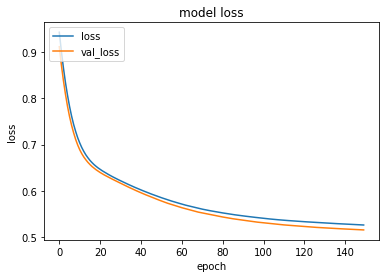

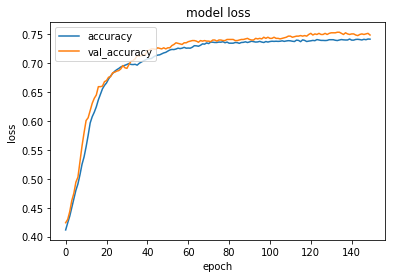

Our accuracy is 75.54%
Our AUC is 79.82%


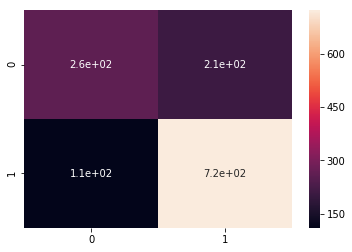

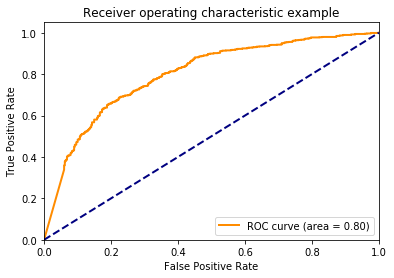

node = 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 3)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00116: early stopping


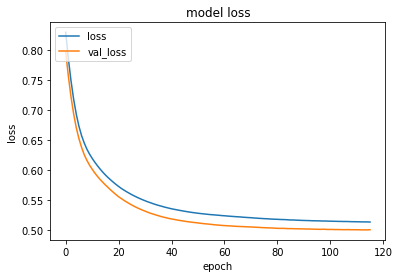

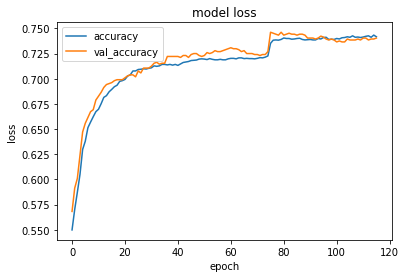

Our accuracy is 74.31%
Our AUC is 80.1%


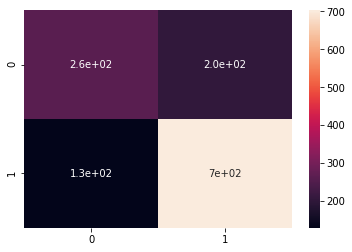

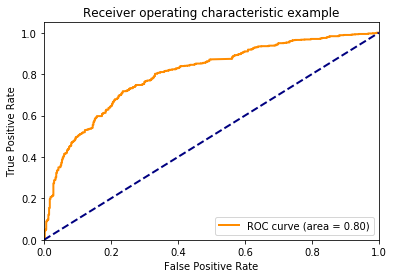

node = 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 4)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00075: early stopping


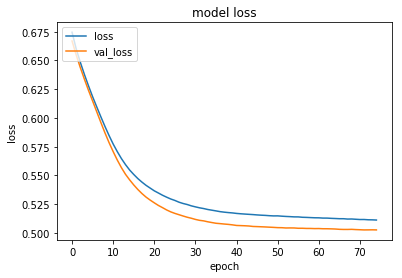

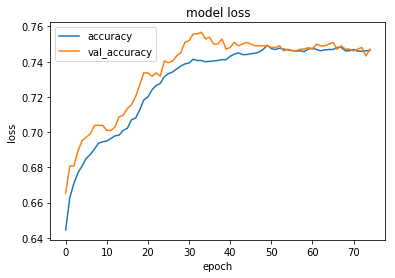

Our accuracy is 74.77%
Our AUC is 80.57%


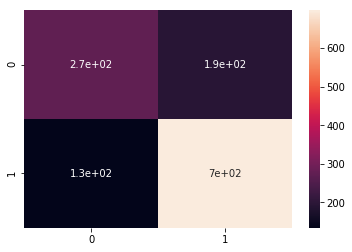

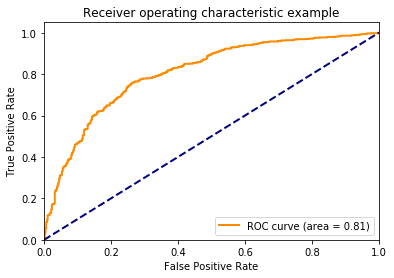

node = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 5)                 60        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00095: early stopping


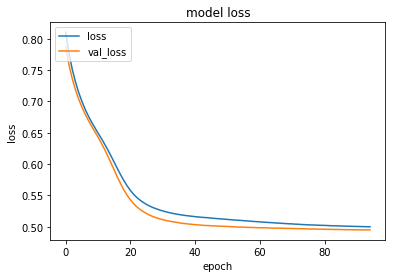

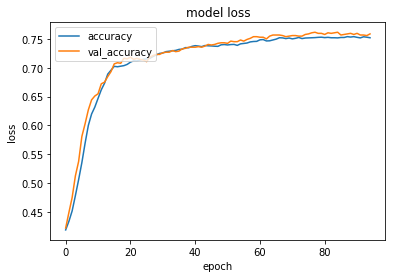

Our accuracy is 76.92%
Our AUC is 81.77%


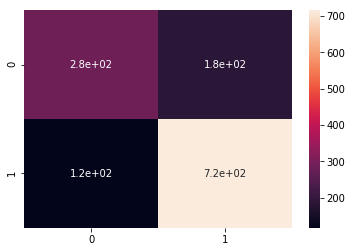

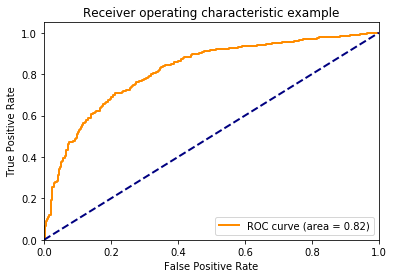

node = 6
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 6)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00104: early stopping


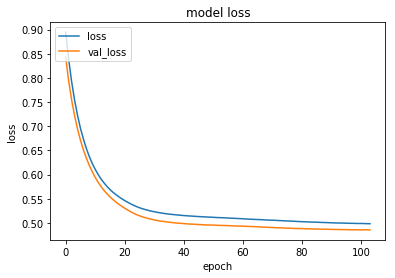

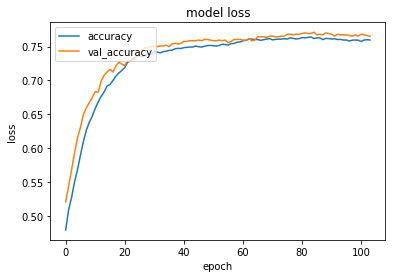

Our accuracy is 76.77%
Our AUC is 81.47%


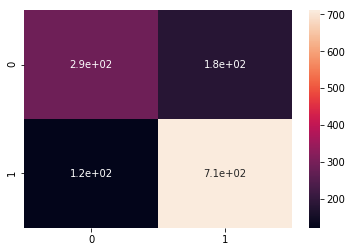

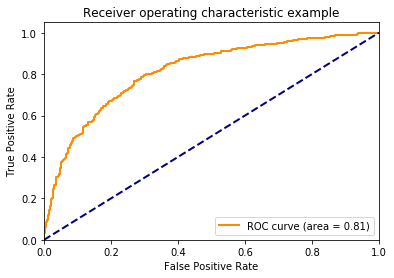

node = 7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 7)                 84        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


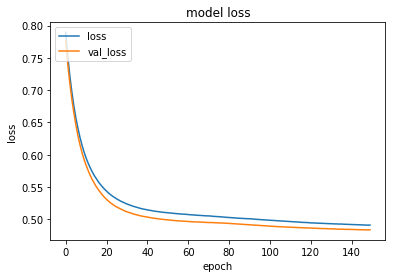

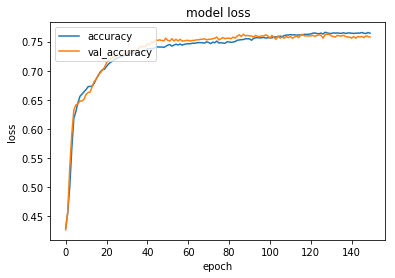

Our accuracy is 75.92%
Our AUC is 81.17%


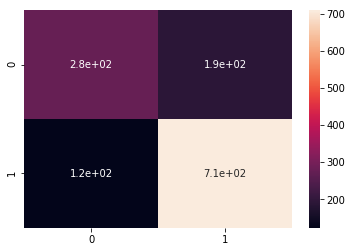

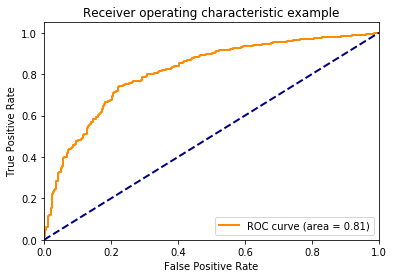

node = 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 8)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00086: early stopping


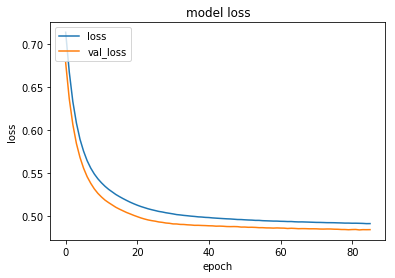

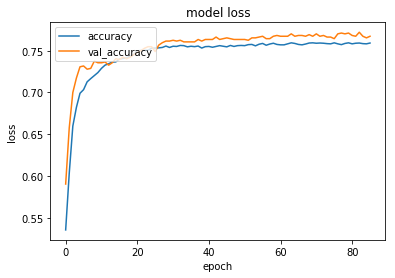

Our accuracy is 76.08%
Our AUC is 82.35%


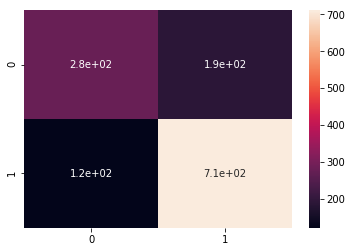

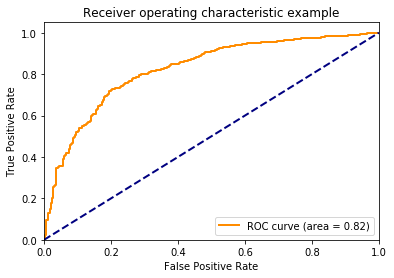

node = 9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 9)                 108       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 118
Trainable params: 118
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00140: early stopping


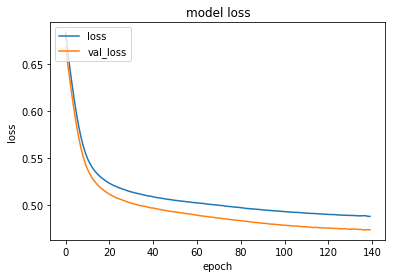

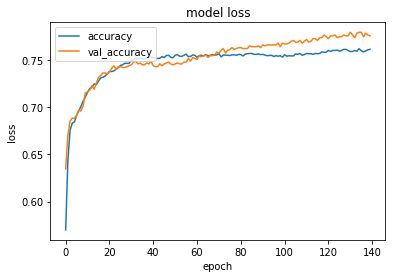

Our accuracy is 76.62%
Our AUC is 81.78%


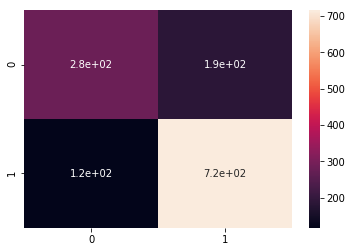

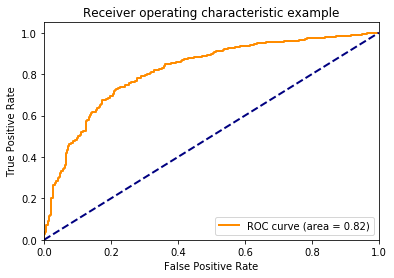

node = 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00108: early stopping


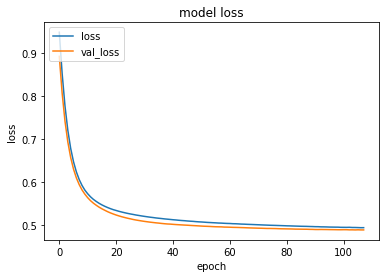

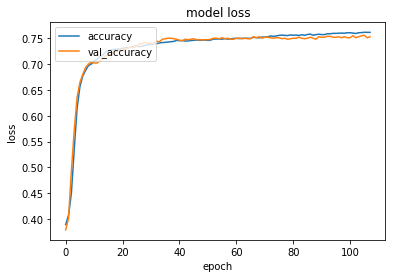

Our accuracy is 76.15%
Our AUC is 81.29%


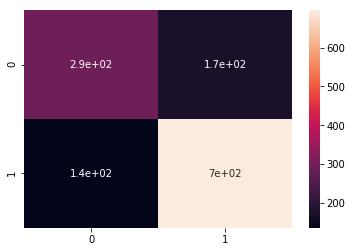

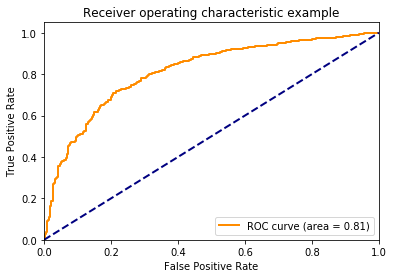

node = 11
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 11)                132       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 12        
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00114: early stopping


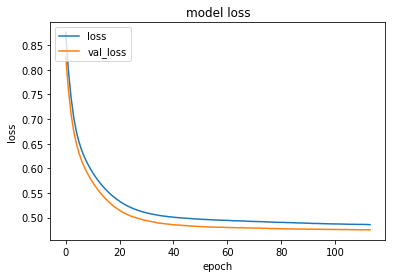

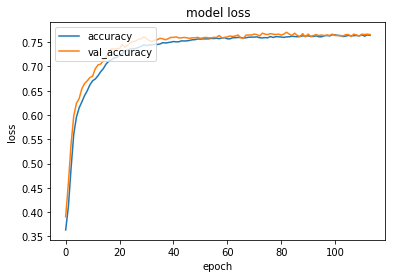

Our accuracy is 76.46%
Our AUC is 82.02%


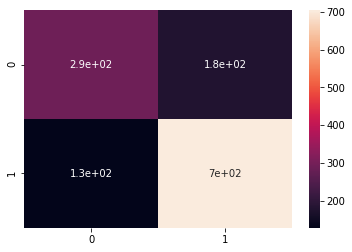

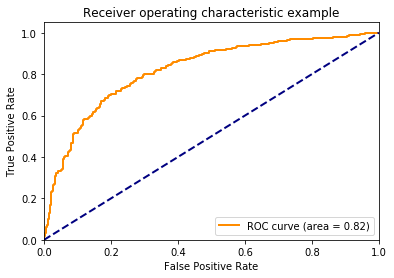

node = 12
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 12)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00073: early stopping


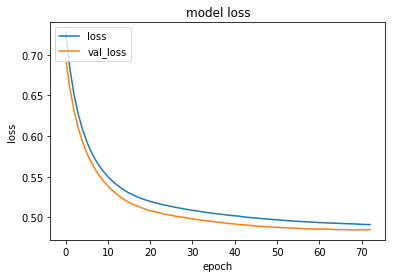

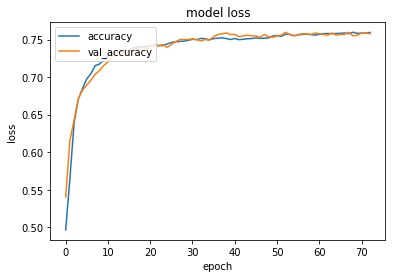

Our accuracy is 77.31%
Our AUC is 82.63%


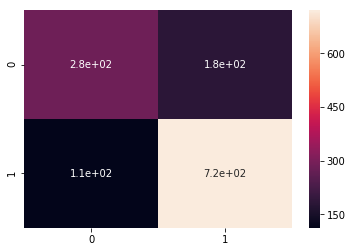

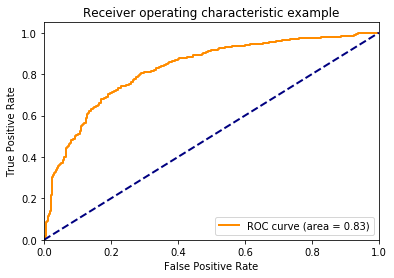

node = 13
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 13)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 14        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00097: early stopping


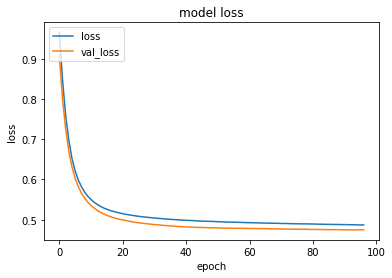

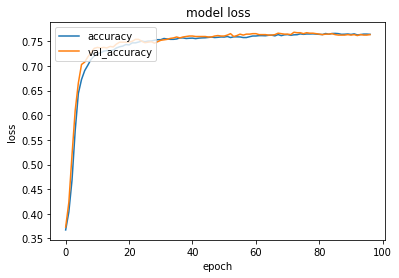

Our accuracy is 75.92%
Our AUC is 82.15%


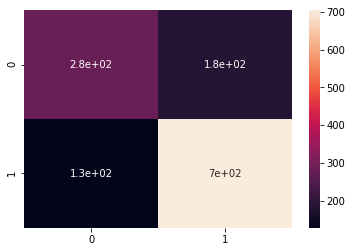

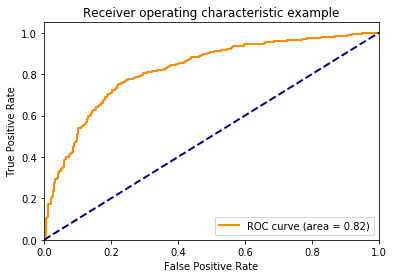

node = 14
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 14)                168       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 183
Trainable params: 183
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00070: early stopping


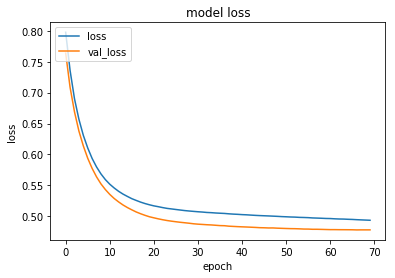

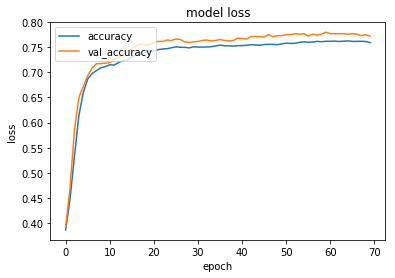

Our accuracy is 76.38%
Our AUC is 81.49%


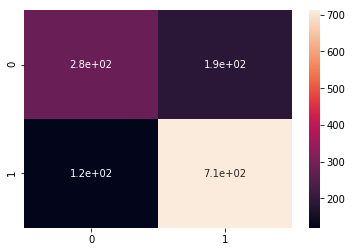

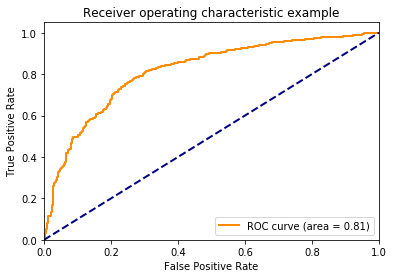

In [38]:
#只用NN
result_NN={}
for i_node in range(2,15):
    print('node =',i_node)
    model = ModelCompile(i_node)
    weights = model.get_weights() 
    model, weights = ModelFit(model=model, weights=weights, epochs=150)
    result_NN[str(i_node)+'Node_acc'+'_AUC']= Performance(model)

In [39]:
result_NN

{'2Node_acc_AUC': (75.54, 79.82),
 '3Node_acc_AUC': (74.31, 80.1),
 '4Node_acc_AUC': (74.77, 80.57),
 '5Node_acc_AUC': (76.92, 81.77),
 '6Node_acc_AUC': (76.77, 81.47),
 '7Node_acc_AUC': (75.92, 81.17),
 '8Node_acc_AUC': (76.08, 82.35),
 '9Node_acc_AUC': (76.62, 81.78),
 '10Node_acc_AUC': (76.15, 81.29),
 '11Node_acc_AUC': (76.46, 82.02),
 '12Node_acc_AUC': (77.31, 82.63),
 '13Node_acc_AUC': (75.92, 82.15),
 '14Node_acc_AUC': (76.38, 81.49)}

## 只用ES

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 2)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.5648  - BEST Score(Log Loss): 0.7298 
ES STEPS: 0  - BEST Accuracy: 0.5663  - BEST Score(Log Loss): 0.7021 
ES STEPS: 0  - BEST Accuracy: 0.5822  - BEST Score(Log Loss): 0.6552 
ES STEPS: 0  - BEST Accuracy: 0.6774  - BEST Score(Log Loss): 0.6199 
ES STEPS: 0  - BEST Accuracy: 0.6500  - BEST Score(Log Loss): 0.5987 
ES STEPS: 1  - BEST Accuracy: 0.6500  - BEST Score(Log Loss): 0.5987 
ES STEPS: 0  - BEST Accuracy: 0.7000  - BEST Score(Log Loss): 0.5853 
ES STEPS: 0  - BEST Accuracy: 0.7099  - BEST Score(L

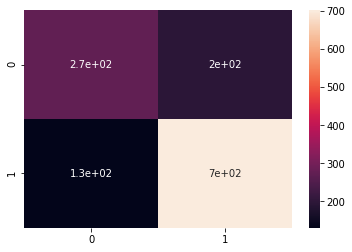

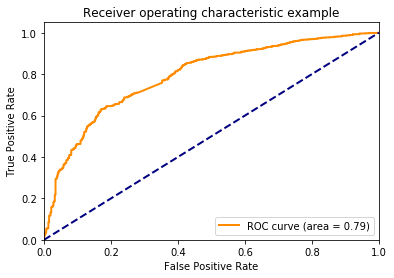

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 3)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.5639  - BEST Score(Log Loss): 0.7012 
ES STEPS: 0  - BEST Accuracy: 0.6582  - BEST Score(Log Loss): 0.6390 
ES STEPS: 1  - BEST Accuracy: 0.6582  - BEST Score(Log Loss): 0.6390 
ES STEPS: 0  - BEST Accuracy: 0.6808  - BEST Score(Log Loss): 0.6120 
ES STEPS: 0  - BEST Accuracy: 0.6810  - BEST Score(Log Loss): 0.6104 
ES STEPS: 1  - BEST Accuracy: 0.6810  - BEST Score(Log Loss): 0.6104 
ES STEPS: 2  - BEST Accuracy: 0.6810  - BEST Score(Log Loss): 0.6104 
ES STEPS: 0  - BEST Accuracy: 0.7012  - BEST Score(L

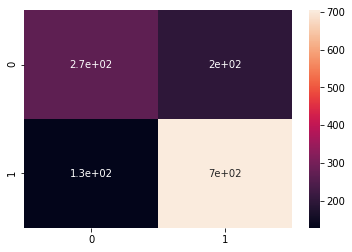

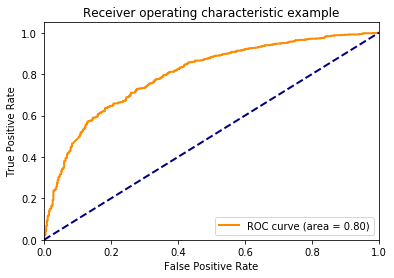

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 4)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.4123  - BEST Score(Log Loss): 0.7820 
ES STEPS: 0  - BEST Accuracy: 0.5619  - BEST Score(Log Loss): 0.7361 
ES STEPS: 0  - BEST Accuracy: 0.6411  - BEST Score(Log Loss): 0.6610 
ES STEPS: 0  - BEST Accuracy: 0.6490  - BEST Score(Log Loss): 0.6279 
ES STEPS: 0  - BEST Accuracy: 0.6791  - BEST Score(Log Loss): 0.5920 
ES STEPS: 0  - BEST Accuracy: 0.6885  - BEST Score(Log Loss): 0.5765 
ES STEPS: 0  - BEST Accuracy: 0.6849  - BEST Score(Log Loss): 0.5708 
ES STEPS: 0  - BEST Accuracy: 0.6902  - BEST Score(L

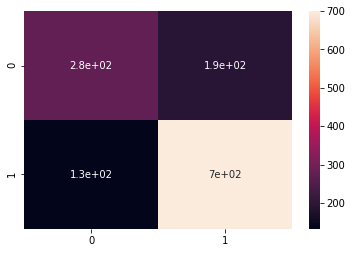

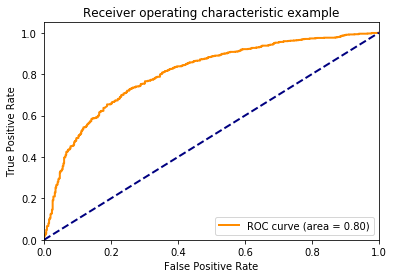

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 5)                 60        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.6315  - BEST Score(Log Loss): 0.6272 
ES STEPS: 0  - BEST Accuracy: 0.6822  - BEST Score(Log Loss): 0.5896 
ES STEPS: 0  - BEST Accuracy: 0.6534  - BEST Score(Log Loss): 0.5844 
ES STEPS: 0  - BEST Accuracy: 0.6714  - BEST Score(Log Loss): 0.5687 
ES STEPS: 1  - BEST Accuracy: 0.6714  - BEST Score(Log Loss): 0.5687 
ES STEPS: 2  - BEST Accuracy: 0.6714  - BEST Score(Log Loss): 0.5687 
ES STEPS: 3  - BEST Accuracy: 0.6714  - BEST Score(Log Loss): 0.5687 
Stop: Reach max_steps
ES STEPS: 0  - BEST Accuracy: 

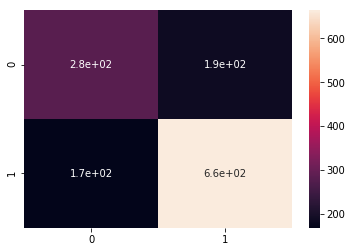

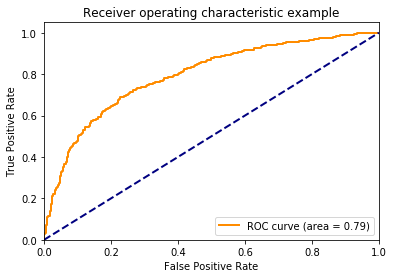

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 6)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.6329  - BEST Score(Log Loss): 0.6674 
ES STEPS: 0  - BEST Accuracy: 0.6536  - BEST Score(Log Loss): 0.6179 
ES STEPS: 0  - BEST Accuracy: 0.7036  - BEST Score(Log Loss): 0.5720 
ES STEPS: 1  - BEST Accuracy: 0.7036  - BEST Score(Log Loss): 0.5720 
ES STEPS: 2  - BEST Accuracy: 0.7036  - BEST Score(Log Loss): 0.5720 
ES STEPS: 3  - BEST Accuracy: 0.7036  - BEST Score(Log Loss): 0.5720 
Stop: Reach max_steps
ES STEPS: 0  - BEST Accuracy: 0.7056  - BEST Score(Log Loss): 0.5675 
ES STEPS: 0  - BEST Accuracy: 

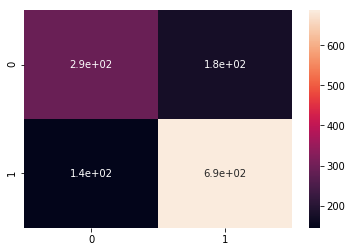

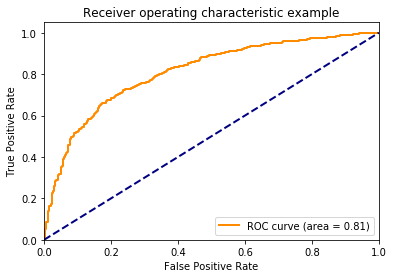

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 7)                 84        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.5769  - BEST Score(Log Loss): 0.7451 
ES STEPS: 0  - BEST Accuracy: 0.5588  - BEST Score(Log Loss): 0.6993 
ES STEPS: 0  - BEST Accuracy: 0.6166  - BEST Score(Log Loss): 0.6827 
ES STEPS: 0  - BEST Accuracy: 0.6413  - BEST Score(Log Loss): 0.6135 
ES STEPS: 0  - BEST Accuracy: 0.6695  - BEST Score(Log Loss): 0.5883 
ES STEPS: 0  - BEST Accuracy: 0.6959  - BEST Score(Log Loss): 0.5800 
ES STEPS: 1  - BEST Accuracy: 0.6959  - BEST Score(Log Loss): 0.5800 
ES STEPS: 2  - BEST Accuracy: 0.6959  - BEST Score(L

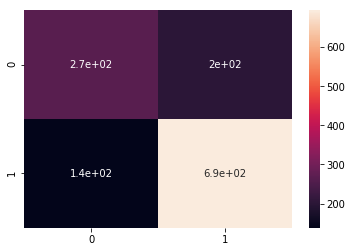

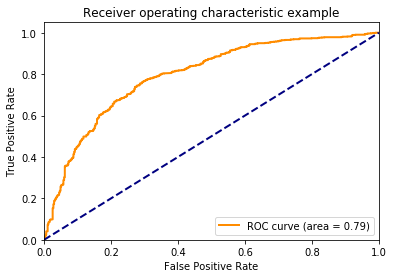

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 8)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.5237  - BEST Score(Log Loss): 0.7172 
ES STEPS: 0  - BEST Accuracy: 0.6113  - BEST Score(Log Loss): 0.6636 
ES STEPS: 0  - BEST Accuracy: 0.7166  - BEST Score(Log Loss): 0.5778 
ES STEPS: 1  - BEST Accuracy: 0.7166  - BEST Score(Log Loss): 0.5778 
ES STEPS: 0  - BEST Accuracy: 0.7176  - BEST Score(Log Loss): 0.5633 
ES STEPS: 1  - BEST Accuracy: 0.7176  - BEST Score(Log Loss): 0.5633 
ES STEPS: 2  - BEST Accuracy: 0.7176  - BEST Score(Log Loss): 0.5633 
ES STEPS: 3  - BEST Accuracy: 0.7176  - BEST Score

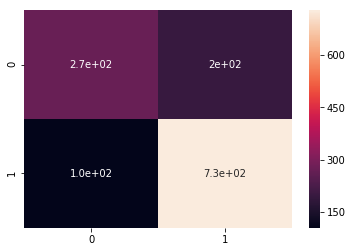

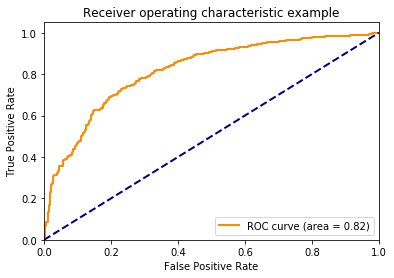

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 9)                 108       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 118
Trainable params: 118
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.6627  - BEST Score(Log Loss): 0.6255 
ES STEPS: 1  - BEST Accuracy: 0.6627  - BEST Score(Log Loss): 0.6255 
ES STEPS: 2  - BEST Accuracy: 0.6627  - BEST Score(Log Loss): 0.6255 
ES STEPS: 3  - BEST Accuracy: 0.6627  - BEST Score(Log Loss): 0.6255 
Stop: Reach max_steps
ES STEPS: 0  - BEST Accuracy: 0.6844  - BEST Score(Log Loss): 0.6021 
ES STEPS: 0  - BEST Accuracy: 0.6846  - BEST Score(Log Loss): 0.5923 
ES STEPS: 0  - BEST Accuracy: 0.6767  - BEST Score(Log Loss): 0.5795 
ES STEPS: 1  - BEST Accuracy

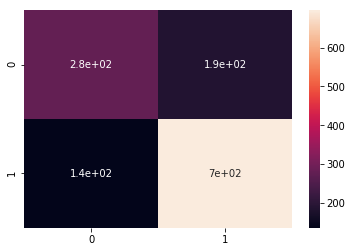

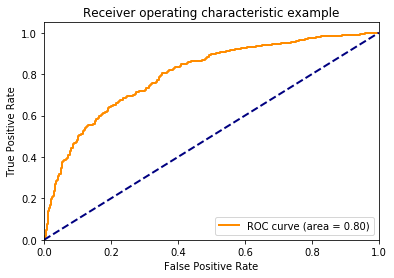

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.6543  - BEST Score(Log Loss): 0.6237 
ES STEPS: 0  - BEST Accuracy: 0.6471  - BEST Score(Log Loss): 0.6019 
ES STEPS: 0  - BEST Accuracy: 0.6707  - BEST Score(Log Loss): 0.5929 
ES STEPS: 0  - BEST Accuracy: 0.6894  - BEST Score(Log Loss): 0.5861 
ES STEPS: 0  - BEST Accuracy: 0.6817  - BEST Score(Log Loss): 0.5823 
ES STEPS: 0  - BEST Accuracy: 0.6926  - BEST Score(Log Loss): 0.5720 
ES STEPS: 0  - BEST Accuracy: 0.7024  - BEST Score(Log Loss): 0.5656 
ES STEPS: 0  - BEST Accuracy: 0.6957  - BEST Score

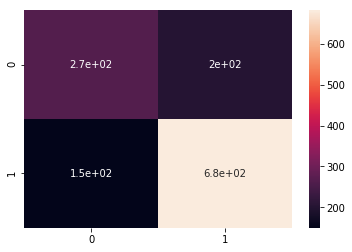

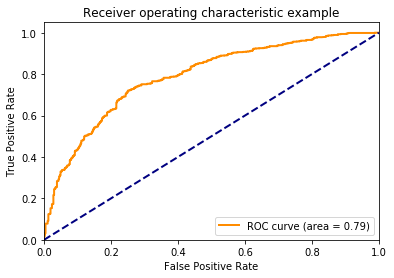

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 11)                132       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 12        
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.5242  - BEST Score(Log Loss): 0.8283 
ES STEPS: 1  - BEST Accuracy: 0.5242  - BEST Score(Log Loss): 0.8283 
ES STEPS: 2  - BEST Accuracy: 0.5242  - BEST Score(Log Loss): 0.8283 
ES STEPS: 3  - BEST Accuracy: 0.5242  - BEST Score(Log Loss): 0.8283 
Stop: Reach max_steps
ES STEPS: 0  - BEST Accuracy: 0.5906  - BEST Score(Log Loss): 0.7212 
ES STEPS: 0  - BEST Accuracy: 0.6464  - BEST Score(Log Loss): 0.6287 
ES STEPS: 1  - BEST Accuracy: 0.6464  - BEST Score(Log Loss): 0.6287 
ES STEPS: 2  - BEST Accuracy

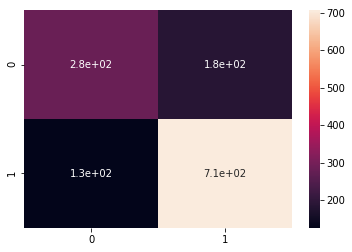

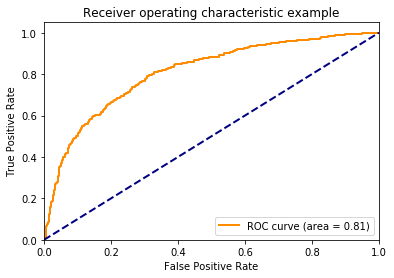

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 12)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.5109  - BEST Score(Log Loss): 0.7710 
ES STEPS: 0  - BEST Accuracy: 0.5268  - BEST Score(Log Loss): 0.7421 
ES STEPS: 0  - BEST Accuracy: 0.5947  - BEST Score(Log Loss): 0.6839 
ES STEPS: 0  - BEST Accuracy: 0.6259  - BEST Score(Log Loss): 0.6292 
ES STEPS: 0  - BEST Accuracy: 0.6457  - BEST Score(Log Loss): 0.5989 
ES STEPS: 0  - BEST Accuracy: 0.6531  - BEST Score(Log Loss): 0.5849 
ES STEPS: 0  - BEST Accuracy: 0.6558  - BEST Score(Log Loss): 0.5788 
ES STEPS: 0  - BEST Accuracy: 0.6829  - BEST Score

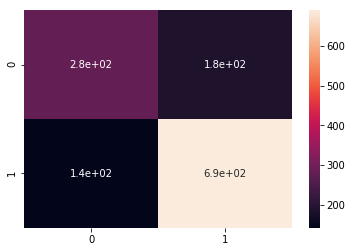

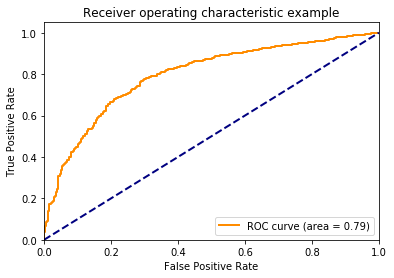

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 13)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 14        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.6752  - BEST Score(Log Loss): 0.6212 
ES STEPS: 0  - BEST Accuracy: 0.6798  - BEST Score(Log Loss): 0.5991 
ES STEPS: 1  - BEST Accuracy: 0.6798  - BEST Score(Log Loss): 0.5991 
ES STEPS: 0  - BEST Accuracy: 0.6986  - BEST Score(Log Loss): 0.5782 
ES STEPS: 0  - BEST Accuracy: 0.7277  - BEST Score(Log Loss): 0.5494 
ES STEPS: 1  - BEST Accuracy: 0.7277  - BEST Score(Log Loss): 0.5494 
ES STEPS: 2  - BEST Accuracy: 0.7277  - BEST Score(Log Loss): 0.5494 
ES STEPS: 3  - BEST Accuracy: 0.7277  - BEST Score

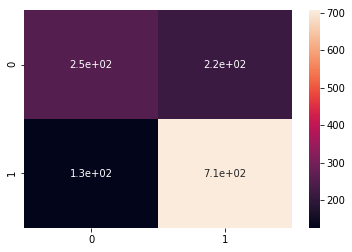

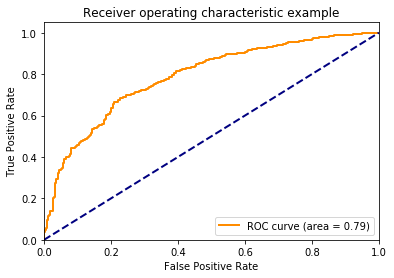

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 14)                168       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 183
Trainable params: 183
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.6690  - BEST Score(Log Loss): 0.5987 
ES STEPS: 0  - BEST Accuracy: 0.6579  - BEST Score(Log Loss): 0.5829 
ES STEPS: 1  - BEST Accuracy: 0.6579  - BEST Score(Log Loss): 0.5829 
ES STEPS: 2  - BEST Accuracy: 0.6579  - BEST Score(Log Loss): 0.5829 
ES STEPS: 3  - BEST Accuracy: 0.6579  - BEST Score(Log Loss): 0.5829 
Stop: Reach max_steps
ES STEPS: 0  - BEST Accuracy: 0.6844  - BEST Score(Log Loss): 0.5698 
ES STEPS: 1  - BEST Accuracy: 0.6844  - BEST Score(Log Loss): 0.5698 
ES STEPS: 2  - BEST Accuracy

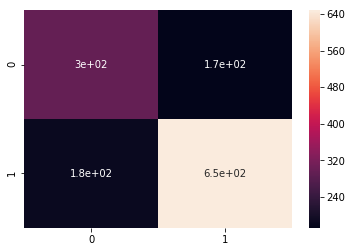

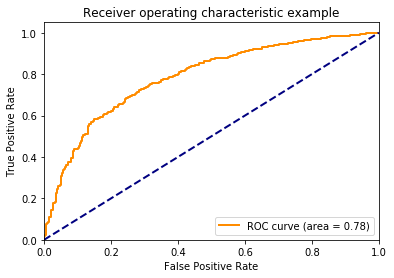

In [42]:
result_ES={}
for i_node in range(2,15):
    # Initialize
    model = ModelCompile(i_node)
    weights = model.get_weights() 
    MyES = ES(model, X_train, y_train, InitialSigma = 0.1, ParentsSize = 15, ChildSize = 100, tao = 0.5)   
    weights, ES_Optimized_ObjVal, _, _  = MyES.run(weights, useOLSReg =False, max_steps=3, verbose = 1)

    # Optimize
    GlobalBestAccuracy = 10
    NoImproveTimes = 0
    while True:
      # Gradient-based Optimize
      #model, weights = ModelFit(model=model, weights=weights, epochs=50)

      # ES
      weights, ES_Optimized_ObjVal, _, _ = MyES.run(weights, max_steps=5, verbose = 1)
      #model.set_weights(weights)    

      # Stop Criteria  
      if ES_Optimized_ObjVal < GlobalBestAccuracy:
        GlobalBestAccuracy = ES_Optimized_ObjVal
        NoImproveTimes = 0
      else: 
        NoImproveTimes = NoImproveTimes + 1
        if NoImproveTimes == 2:
          break

    model.set_weights(weights)   
    result_ES[str(i_node)+'Node_acc'+'_AUC']= Performance(model)

In [43]:
result_ES

{'2Node_acc_AUC': (75.0, 79.2),
 '3Node_acc_AUC': (74.85, 79.87),
 '4Node_acc_AUC': (74.92, 80.26),
 '5Node_acc_AUC': (72.69, 79.33),
 '6Node_acc_AUC': (75.38, 81.04),
 '7Node_acc_AUC': (73.85, 79.34),
 '8Node_acc_AUC': (76.85, 81.69),
 '9Node_acc_AUC': (75.08, 79.93),
 '10Node_acc_AUC': (72.92, 78.85),
 '11Node_acc_AUC': (76.08, 80.87),
 '12Node_acc_AUC': (74.85, 79.5),
 '13Node_acc_AUC': (73.77, 78.78),
 '14Node_acc_AUC': (72.62, 78.49)}

##  只用ES ParentsSize = #param x2, ChildSize = ParentsSize x7

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
IntermediateLayer (Dense)    (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.4186  - BEST Score(Log Loss): 0.7805 
ES STEPS: 0  - BEST Accuracy: 0.6372  - BEST Score(Log Loss): 0.6434 
ES STEPS: 0  - BEST Accuracy: 0.6375  - BEST Score(Log Loss): 0.6170 
ES STEPS: 0  - BEST Accuracy: 0.6731  - BEST Score(Log Loss): 0.60

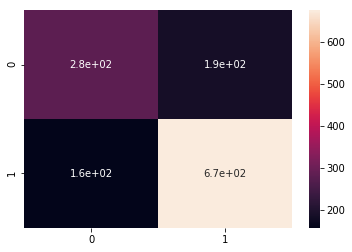

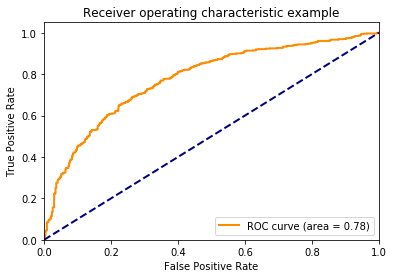

In [27]:
# Initialize
model = ModelCompile()
weights = model.get_weights() 
MyES = ES(model, X_train, y_train, InitialSigma = 0.1, ParentsSize = model.count_params()*2, ChildSize = model.count_params()*2*7, tao = 0.5)   
weights, ES_Optimized_ObjVal, _, _  = MyES.run(weights, useOLSReg =False, max_steps=3, verbose = 1)

# Optimize
GlobalBestAccuracy = 0
NoImproveTimes = 0
while True:
  # Gradient-based Optimize
  # model, weights = ModelFit(model=model, weights=weights, epochs=50)

  # ES
  weights, ES_Optimized_ObjVal,_,_ = MyES.run(weights, max_steps=20, verbose = 1)

  # Stop Criteria
  if ES_Optimized_ObjVal > GlobalBestAccuracy:
    GlobalBestAccuracy = ES_Optimized_ObjVal
    NoImproveTimes = 0
  else: 
    NoImproveTimes = NoImproveTimes + 1
    if NoImproveTimes == 2:
      break

model.set_weights(weights)
Performance(model)

## 只用ES with MultiPhase

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
IntermediateLayer (Dense)    (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.5872  - BEST Score(Log Loss): 0.6892 
ES STEPS: 0  - BEST Accuracy: 0.6151  - BEST Score(Log Loss): 0.6670 
ES STEPS: 0  - BEST Accuracy: 0.6401  - BEST Score(Log Loss): 0.6401 
ES STEPS: 1  - BEST Accuracy: 0.6401  - BEST Score(Log Loss): 0.64

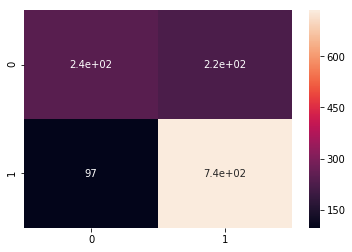

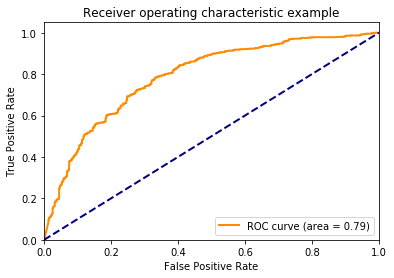

In [22]:
# Initialize
model = ModelCompile()
weights = model.get_weights() 
MyES = ES(model, X_train, y_train, InitialSigma = 0.1, ParentsSize = 15, ChildSize = 100, tao = 0.5)   
weights, ES_Optimized_ObjVal, P_Best10_Weights, P_Best10_Sigma  = MyES.run(weights, useOLSReg =False, max_steps=3, verbose = 1)

# Optimize
GlobalBestAccuracy = 0
NoImproveTimes = 0
while True:
  # ES
  weights, ES_Optimized_ObjVal, P_Best10_Weights, P_Best10_Sigma = MyES.run(weights, max_steps=20, verbose = 1,
                                                                            Population_Parents_Weights=P_Best10_Weights, 
                                                                            Population_Parents_Sigma=P_Best10_Sigma)
  # Stop Criteria
  if ES_Optimized_ObjVal > GlobalBestAccuracy:
    GlobalBestAccuracy = ES_Optimized_ObjVal
    NoImproveTimes = 0
  else: 
    NoImproveTimes = NoImproveTimes + 1
    if NoImproveTimes == 2:
      break
    
model.set_weights(weights)    
Performance(model)

# Main2 BP + ES

## ParentsSize = 15, ChildSize = 100

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
IntermediateLayer (Dense)    (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.6341  - BEST Score(Log Loss): 0.6620 
ES STEPS: 0  - BEST Accuracy: 0.6433  - BEST Score(Log Loss): 0.6434 
ES STEPS: 0  - BEST Accuracy: 0.6654  - BEST Score(Log Loss): 0.6341 
ES STEPS: 0  - BEST Accuracy: 0.6538  - BEST Score(Log Loss): 0.62

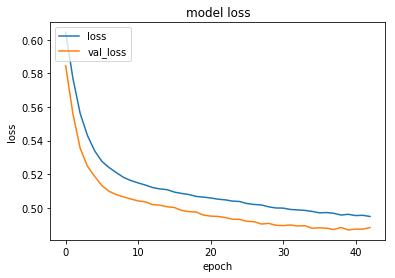

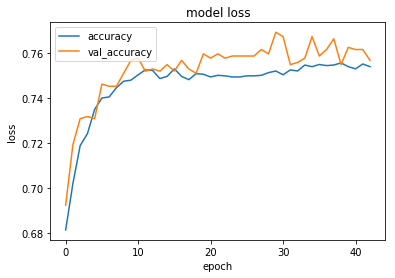

ES STEPS: 1  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 2  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 3  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 4  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 5  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 6  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 7  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 8  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 9  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 10  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 11  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 12  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 13  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 14  - BEST Accuracy: 0.7537  - BEST Score(Log Loss): 0.4942 
ES STEPS: 15  -

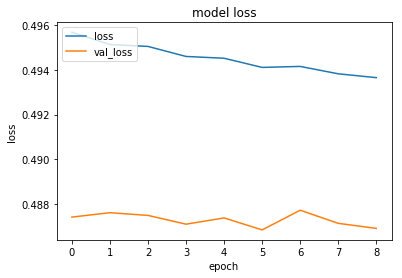

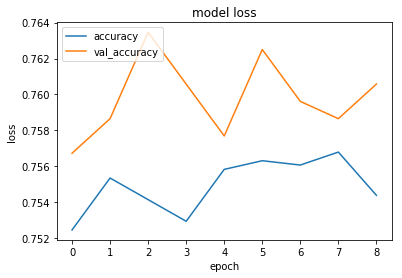

ES STEPS: 1  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 2  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 3  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 4  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 5  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 6  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 7  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 8  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 9  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 10  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 11  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 12  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 13  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 14  - BEST Accuracy: 0.7541  - BEST Score(Log Loss): 0.4927 
ES STEPS: 15  -

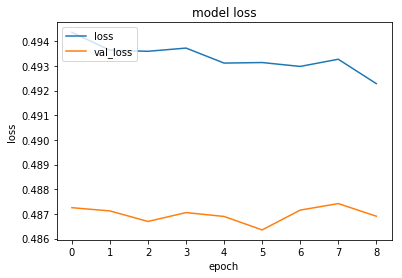

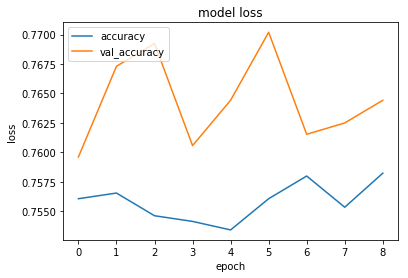

ES STEPS: 1  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 2  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 3  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 4  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 5  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 6  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 7  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 8  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 9  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 10  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 11  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 12  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 13  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 14  - BEST Accuracy: 0.7554  - BEST Score(Log Loss): 0.4918 
ES STEPS: 15  -

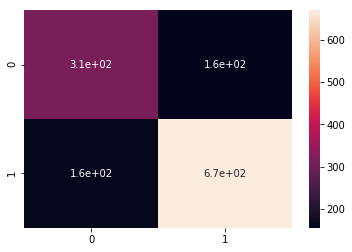

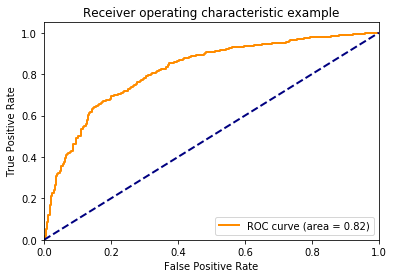

In [23]:
# Initialize
model = ModelCompile()
weights = model.get_weights() 
MyES = ES(model, X_train, y_train, InitialSigma = 0.1, ParentsSize = 15, ChildSize = 100, tao = 0.5)   
weights, ES_Optimized_ObjVal, _, _  = MyES.run(weights, useOLSReg =False, max_steps=3, verbose = 1)

# Optimize
GlobalBestAccuracy = 0
NoImproveTimes = 0
while True:
  # Gradient-based Optimize
  model, weights = ModelFit(model=model, weights=weights, epochs=50)
  # ES
  weights, ES_Optimized_ObjVal, _, _ = MyES.run(weights, max_steps=20, verbose = 1)
    
  # Stop Criteria
  if ES_Optimized_ObjVal > GlobalBestAccuracy:
    GlobalBestAccuracy = ES_Optimized_ObjVal
    NoImproveTimes = 0
  else: 
    NoImproveTimes = NoImproveTimes + 1
    if NoImproveTimes == 2:
      break

model.set_weights(weights)
Performance(model)

## ParentsSize = #param x2, ChildSize = ParentsSize x7

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
IntermediateLayer (Dense)    (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.6081  - BEST Score(Log Loss): 0.6662 
ES STEPS: 0  - BEST Accuracy: 0.6401  - BEST Score(Log Loss): 0.6499 
ES STEPS: 0  - BEST Accuracy: 0.6510  - BEST Score(Log Loss): 0.6397 
ES STEPS: 0  - BEST Accuracy: 0.6454  - BEST Score(Log Loss): 0.63

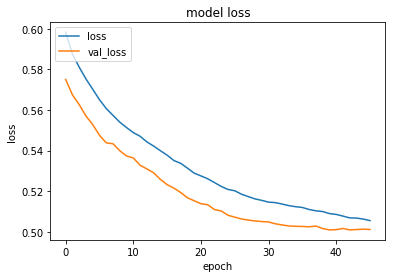

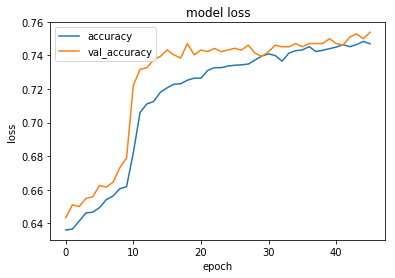

ES STEPS: 1  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 2  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 3  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 4  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 5  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 6  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 7  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 8  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 9  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 10  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 11  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 12  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 13  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 14  - BEST Accuracy: 0.7469  - BEST Score(Log Loss): 0.5051 
ES STEPS: 15  -

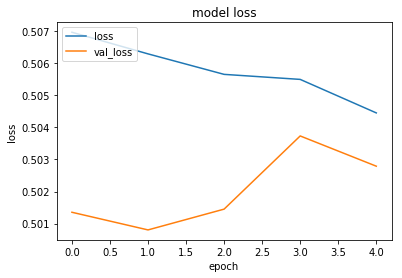

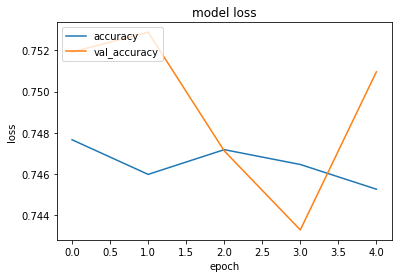

ES STEPS: 1  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 2  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 3  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 4  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 5  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 6  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 7  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 8  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 9  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 10  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 11  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 12  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 13  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 14  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5046 
ES STEPS: 15  -

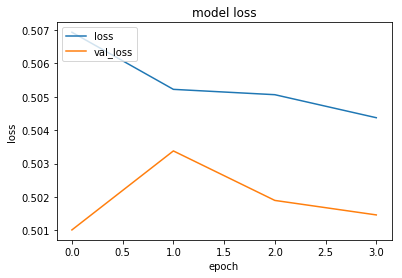

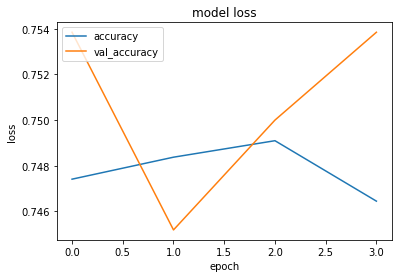

ES STEPS: 1  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 2  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 3  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 4  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 5  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 6  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 7  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 8  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 9  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 10  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 11  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 12  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 13  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 14  - BEST Accuracy: 0.7515  - BEST Score(Log Loss): 0.5035 
ES STEPS: 15  -

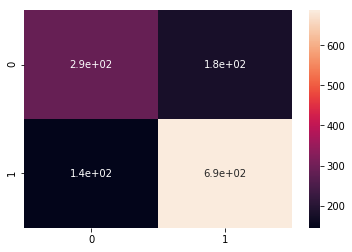

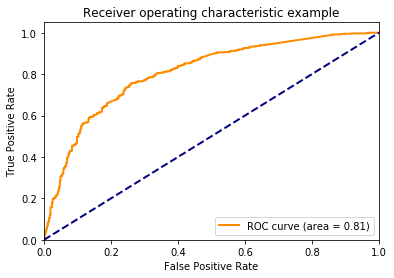

In [24]:
# Initialize
model = ModelCompile()
weights = model.get_weights() 
MyES = ES(model, X_train, y_train, InitialSigma = 0.1, ParentsSize = model.count_params()*2, ChildSize = model.count_params()*2*7, tao = 0.5)   
weights, ES_Optimized_ObjVal, _, _  = MyES.run(weights, useOLSReg =False, max_steps=3, verbose = 1)

# Optimize
GlobalBestAccuracy = 0
NoImproveTimes = 0
while True:
  # Gradient-based Optimize
  model, weights = ModelFit(model=model, weights=weights, epochs=50)

  # ES
  weights, ES_Optimized_ObjVal,_,_ = MyES.run(weights, max_steps=20, verbose = 1)

  # Stop Criteria
  if ES_Optimized_ObjVal > GlobalBestAccuracy:
    GlobalBestAccuracy = ES_Optimized_ObjVal
    NoImproveTimes = 0
  else: 
    NoImproveTimes = NoImproveTimes + 1
    if NoImproveTimes == 2:
      break

model.set_weights(weights)
Performance(model)

## MultiPhase

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
IntermediateLayer (Dense)    (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 0  - BEST Accuracy: 0.6334  - BEST Score(Log Loss): 0.6439 
ES STEPS: 0  - BEST Accuracy: 0.6331  - BEST Score(Log Loss): 0.6109 
ES STEPS: 1  - BEST Accuracy: 0.6331  - BEST Score(Log Loss): 0.6109 
ES STEPS: 0  - BEST Accuracy: 0.6331  - BEST Score(Log Loss): 0.59

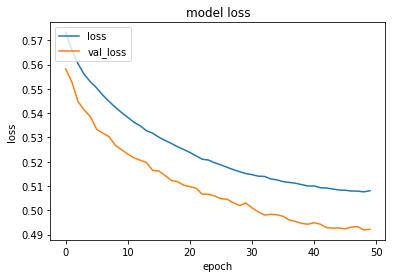

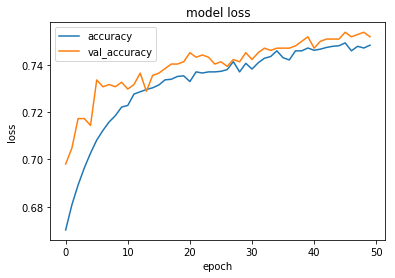

====================== 1 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5788 - acc: 0.6885 - val_loss: 0.5572 - val_acc: 0.7029
Epoch 2/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5693 - acc: 0.6988 - val_loss: 0.5480 - val_acc: 0.7125
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5617 - acc: 0.7063 - val_loss: 0.5423 - val_acc: 0.7173
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5559 - acc: 0.7130 - val_loss: 0.5376 - val_acc: 0.7231
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5517 - acc: 0.7176 - val_loss: 0.5333 - val_acc: 0.7240
Epoch 6/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5472 - acc: 0.7212 - val_loss: 0.5299 - val_acc: 0.7202
Epoch 7/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5436 - acc: 0.7219 - val_loss: 0

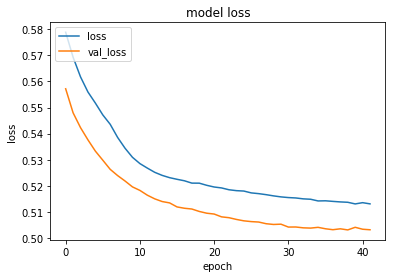

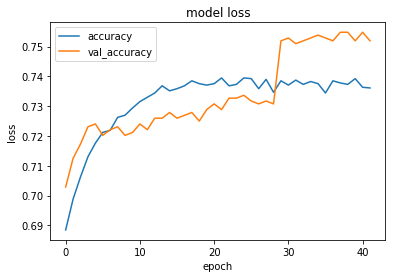

====================== 2 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.5831 - acc: 0.6341 - val_loss: 0.5722 - val_acc: 0.6250
Epoch 2/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5763 - acc: 0.6348 - val_loss: 0.5654 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5708 - acc: 0.6375 - val_loss: 0.5595 - val_acc: 0.6885
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5663 - acc: 0.6752 - val_loss: 0.5552 - val_acc: 0.6923
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5632 - acc: 0.6798 - val_loss: 0.5511 - val_acc: 0.6962
Epoch 6/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5609 - acc: 0.6825 - val_loss: 0.5477 - val_acc: 0.7019
Epoch 7/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5589 - acc: 0.6841 - val_loss: 0

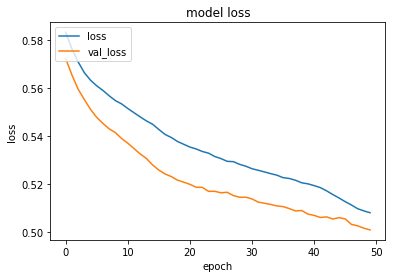

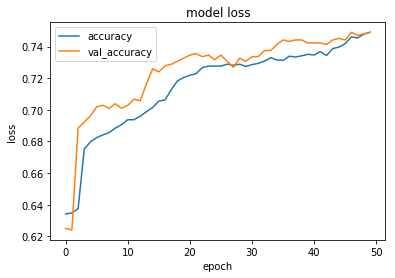

====================== 3 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 78us/step - loss: 0.5736 - acc: 0.6748 - val_loss: 0.5415 - val_acc: 0.7058
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5598 - acc: 0.7003 - val_loss: 0.5351 - val_acc: 0.7183
Epoch 3/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5536 - acc: 0.7082 - val_loss: 0.5311 - val_acc: 0.7250
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5504 - acc: 0.7108 - val_loss: 0.5283 - val_acc: 0.7269
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5473 - acc: 0.7137 - val_loss: 0.5268 - val_acc: 0.7269
Epoch 6/50
4157/4157 [==============================] - 0s 78us/step - loss: 0.5438 - acc: 0.7157 - val_loss: 0.5250 - val_acc: 0.7269
Epoch 7/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.5403 - acc: 0.7231 - val_loss: 0

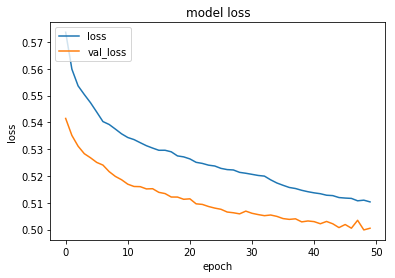

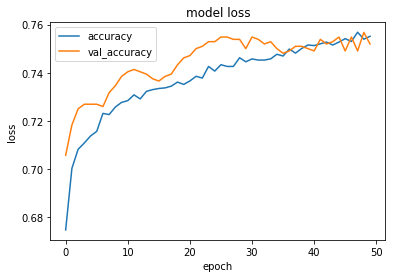

====================== 4 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.5824 - acc: 0.6324 - val_loss: 0.5767 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 78us/step - loss: 0.5754 - acc: 0.6334 - val_loss: 0.5716 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.5716 - acc: 0.6334 - val_loss: 0.5672 - val_acc: 0.6250
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5690 - acc: 0.6327 - val_loss: 0.5643 - val_acc: 0.6250
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5664 - acc: 0.6331 - val_loss: 0.5603 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.5640 - acc: 0.6327 - val_loss: 0.5555 - val_acc: 0.6240
Epoch 7/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5618 - acc: 0.6331 - val_loss: 0

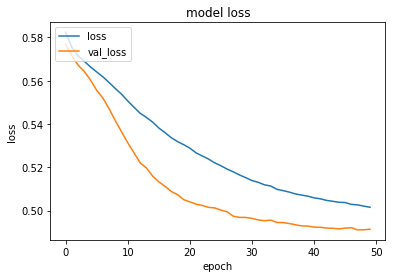

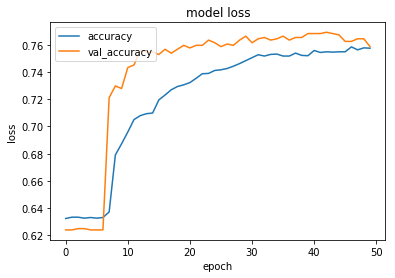

====================== 5 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 78us/step - loss: 0.5839 - acc: 0.6764 - val_loss: 0.5510 - val_acc: 0.7058
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5696 - acc: 0.6851 - val_loss: 0.5409 - val_acc: 0.7135
Epoch 3/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5588 - acc: 0.6979 - val_loss: 0.5350 - val_acc: 0.7183
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5505 - acc: 0.7142 - val_loss: 0.5311 - val_acc: 0.7212
Epoch 5/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.5465 - acc: 0.7207 - val_loss: 0.5282 - val_acc: 0.7240
Epoch 6/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5434 - acc: 0.7248 - val_loss: 0.5252 - val_acc: 0.7192
Epoch 7/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5406 - acc: 0.7243 - val_loss: 0

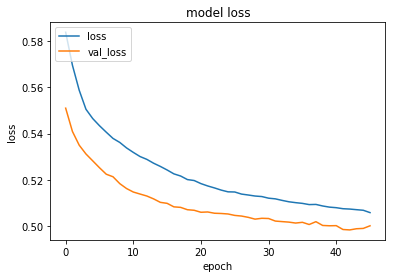

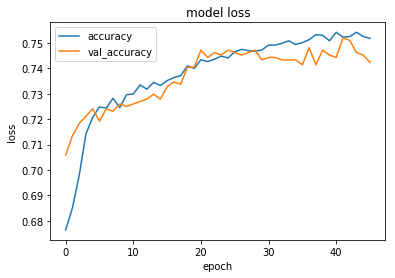

====================== 6 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 78us/step - loss: 0.5820 - acc: 0.6505 - val_loss: 0.5643 - val_acc: 0.6683
Epoch 2/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5721 - acc: 0.6608 - val_loss: 0.5585 - val_acc: 0.6788
Epoch 3/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5680 - acc: 0.6661 - val_loss: 0.5541 - val_acc: 0.6856
Epoch 4/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5655 - acc: 0.6692 - val_loss: 0.5514 - val_acc: 0.6885
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5640 - acc: 0.6712 - val_loss: 0.5497 - val_acc: 0.6856
Epoch 6/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5618 - acc: 0.6760 - val_loss: 0.5484 - val_acc: 0.6875
Epoch 7/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5596 - acc: 0.6784 - val_loss: 0

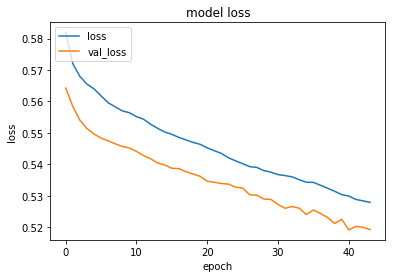

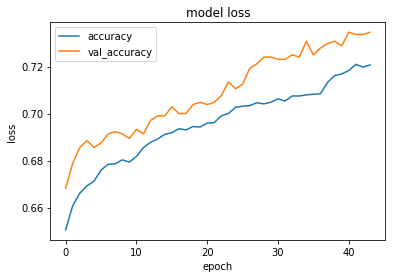

====================== 7 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 78us/step - loss: 0.5776 - acc: 0.6534 - val_loss: 0.5432 - val_acc: 0.6923
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5566 - acc: 0.6885 - val_loss: 0.5282 - val_acc: 0.7327
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5436 - acc: 0.7164 - val_loss: 0.5198 - val_acc: 0.7462
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5348 - acc: 0.7294 - val_loss: 0.5132 - val_acc: 0.7442
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5306 - acc: 0.7327 - val_loss: 0.5101 - val_acc: 0.7481
Epoch 6/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5272 - acc: 0.7383 - val_loss: 0.5073 - val_acc: 0.7567
Epoch 7/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5248 - acc: 0.7474 - val_loss: 0

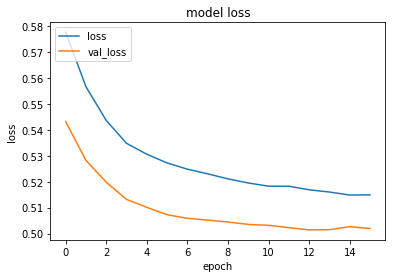

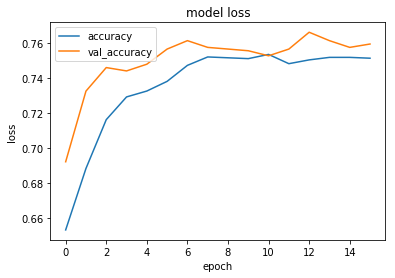

====================== 8 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 79us/step - loss: 0.5750 - acc: 0.6875 - val_loss: 0.5519 - val_acc: 0.7058
Epoch 2/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5512 - acc: 0.7075 - val_loss: 0.5359 - val_acc: 0.7231
Epoch 3/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5396 - acc: 0.7229 - val_loss: 0.5258 - val_acc: 0.7279
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5323 - acc: 0.7337 - val_loss: 0.5197 - val_acc: 0.7356
Epoch 5/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.5279 - acc: 0.7366 - val_loss: 0.5150 - val_acc: 0.7385
Epoch 6/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.5246 - acc: 0.7424 - val_loss: 0.5128 - val_acc: 0.7471
Epoch 7/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5221 - acc: 0.7426 - val_loss: 0

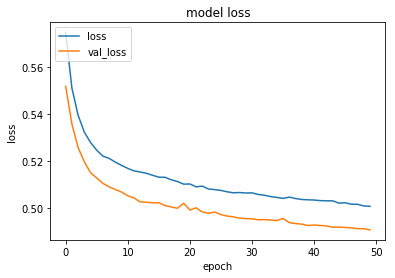

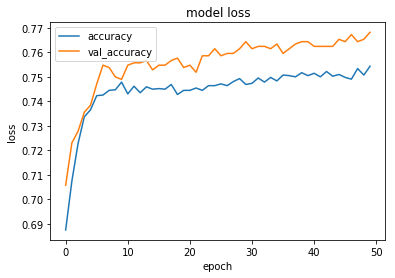

====================== 9 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.5811 - acc: 0.6726 - val_loss: 0.5567 - val_acc: 0.7029
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5582 - acc: 0.6974 - val_loss: 0.5437 - val_acc: 0.7038
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5471 - acc: 0.7087 - val_loss: 0.5361 - val_acc: 0.7125
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5395 - acc: 0.7212 - val_loss: 0.5316 - val_acc: 0.7240
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5354 - acc: 0.7267 - val_loss: 0.5273 - val_acc: 0.7288
Epoch 6/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.5320 - acc: 0.7308 - val_loss: 0.5265 - val_acc: 0.7337
Epoch 7/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.5293 - acc: 0.7378 - val_loss: 0

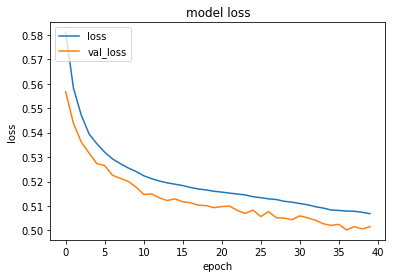

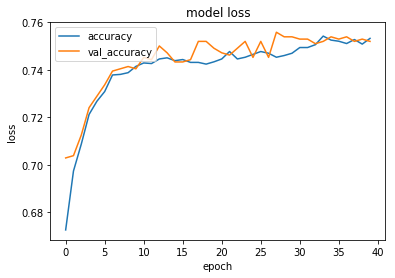

ES STEPS: 1  - BEST Accuracy: 0.7072  - BEST Score(Log Loss): 0.5624 
ES STEPS: 2  - BEST Accuracy: 0.7072  - BEST Score(Log Loss): 0.5624 
ES STEPS: 3  - BEST Accuracy: 0.7072  - BEST Score(Log Loss): 0.5624 
ES STEPS: 4  - BEST Accuracy: 0.7072  - BEST Score(Log Loss): 0.5624 
ES STEPS: 5  - BEST Accuracy: 0.7072  - BEST Score(Log Loss): 0.5624 
ES STEPS: 6  - BEST Accuracy: 0.7072  - BEST Score(Log Loss): 0.5624 
ES STEPS: 7  - BEST Accuracy: 0.7072  - BEST Score(Log Loss): 0.5624 
ES STEPS: 8  - BEST Accuracy: 0.7072  - BEST Score(Log Loss): 0.5624 
ES STEPS: 9  - BEST Accuracy: 0.7072  - BEST Score(Log Loss): 0.5624 
ES STEPS: 10  - BEST Accuracy: 0.7072  - BEST Score(Log Loss): 0.5624 
ES STEPS: 11  - BEST Accuracy: 0.7072  - BEST Score(Log Loss): 0.5624 
ES STEPS: 12  - BEST Accuracy: 0.7072  - BEST Score(Log Loss): 0.5624 
ES STEPS: 0  - BEST Accuracy: 0.7190  - BEST Score(Log Loss): 0.5565 
ES STEPS: 1  - BEST Accuracy: 0.7190  - BEST Score(Log Loss): 0.5565 
ES STEPS: 2  - BE

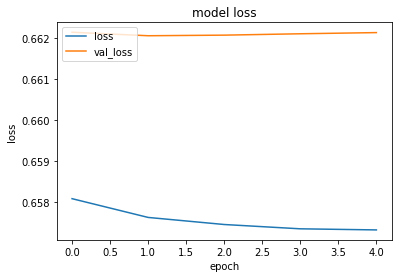

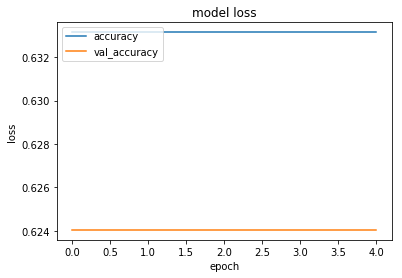

====================== 1 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6586 - acc: 0.6331 - val_loss: 0.6639 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6579 - acc: 0.6331 - val_loss: 0.6632 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6576 - acc: 0.6331 - val_loss: 0.6628 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6574 - acc: 0.6331 - val_loss: 0.6626 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6574 - acc: 0.6331 - val_loss: 0.6625 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 7/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0

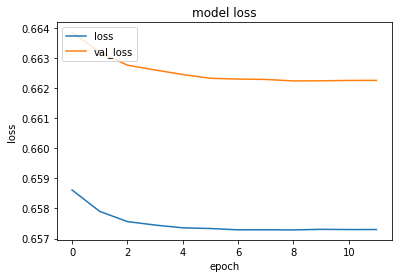

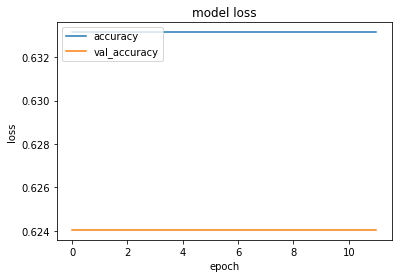

====================== 2 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6594 - acc: 0.6331 - val_loss: 0.6646 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6583 - acc: 0.6331 - val_loss: 0.6636 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6578 - acc: 0.6331 - val_loss: 0.6630 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6575 - acc: 0.6331 - val_loss: 0.6627 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6574 - acc: 0.6331 - val_loss: 0.6626 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6624 - val_acc: 0.6240
Epoch 7/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0

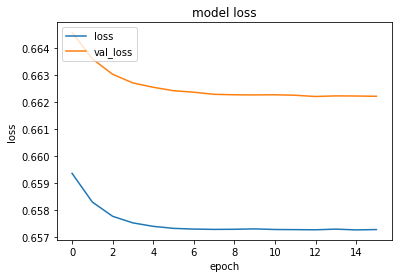

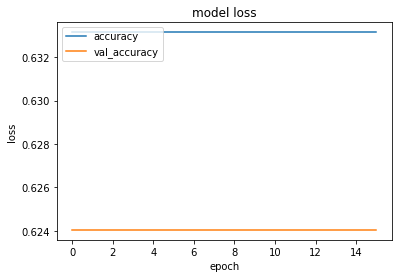

====================== 3 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6595 - acc: 0.6331 - val_loss: 0.6647 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6584 - acc: 0.6331 - val_loss: 0.6637 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6579 - acc: 0.6331 - val_loss: 0.6632 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6576 - acc: 0.6331 - val_loss: 0.6627 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6574 - acc: 0.6331 - val_loss: 0.6626 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6624 - val_acc: 0.6240
Epoch 7/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0

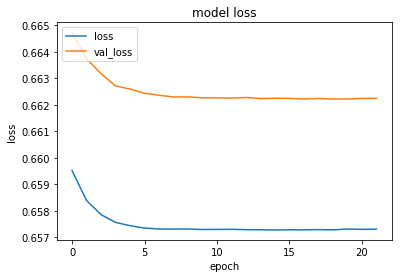

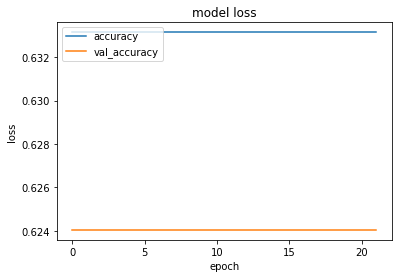

====================== 4 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6595 - acc: 0.6331 - val_loss: 0.6648 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6584 - acc: 0.6331 - val_loss: 0.6637 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6578 - acc: 0.6331 - val_loss: 0.6631 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6575 - acc: 0.6331 - val_loss: 0.6628 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6574 - acc: 0.6331 - val_loss: 0.6625 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6574 - acc: 0.6331 - val_loss: 0.6624 - val_acc: 0.6240
Epoch 7/50
4157/4157 [==============================] - 0s 79us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0

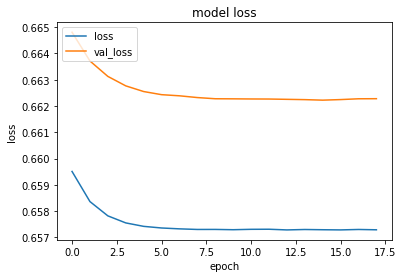

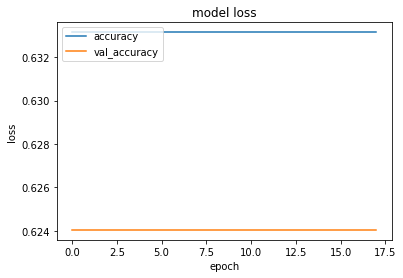

====================== 5 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6602 - acc: 0.6331 - val_loss: 0.6630 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6587 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6580 - acc: 0.6331 - val_loss: 0.6621 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6576 - acc: 0.6331 - val_loss: 0.6621 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6575 - acc: 0.6331 - val_loss: 0.6621 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6574 - acc: 0.6331 - val_loss: 0.6621 - val_acc: 0.6240
Epoch 7/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0

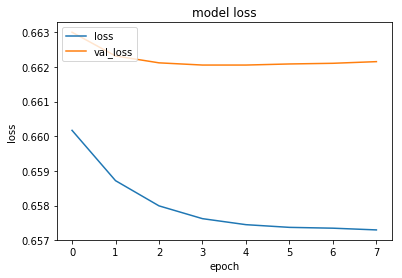

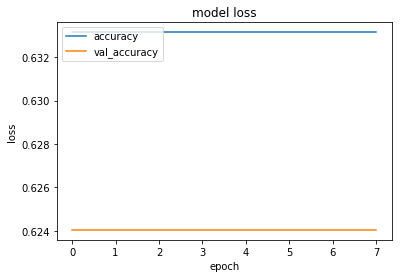

====================== 6 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6639 - acc: 0.6336 - val_loss: 0.6612 - val_acc: 0.6250
Epoch 2/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6639 - acc: 0.6336 - val_loss: 0.6613 - val_acc: 0.6250
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6639 - acc: 0.6336 - val_loss: 0.6612 - val_acc: 0.6250
Epoch 4/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6639 - acc: 0.6336 - val_loss: 0.6612 - val_acc: 0.6250
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


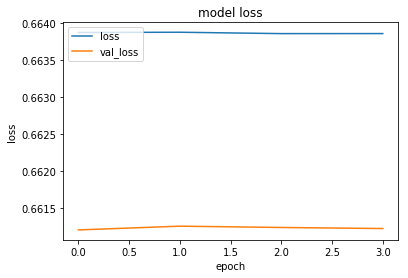

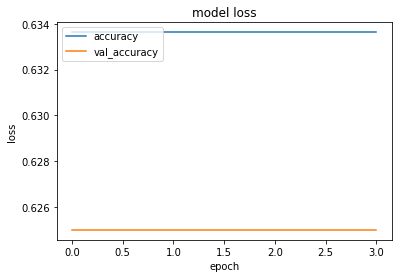

====================== 7 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 78us/step - loss: 0.6654 - acc: 0.6331 - val_loss: 0.6701 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6615 - acc: 0.6331 - val_loss: 0.6666 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 80us/step - loss: 0.6594 - acc: 0.6331 - val_loss: 0.6647 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6584 - acc: 0.6331 - val_loss: 0.6637 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6578 - acc: 0.6331 - val_loss: 0.6631 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6576 - acc: 0.6331 - val_loss: 0.6628 - val_acc: 0.6240
Epoch 7/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6574 - acc: 0.6331 - val_loss: 0

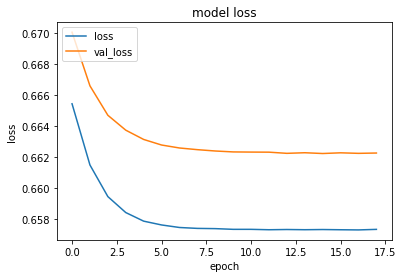

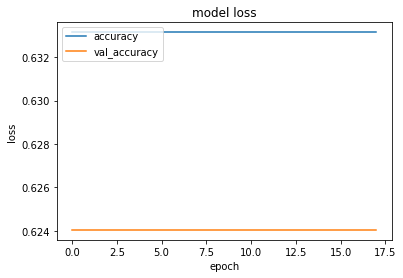

====================== 8 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6667 - acc: 0.6331 - val_loss: 0.6645 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6636 - acc: 0.6331 - val_loss: 0.6629 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6622 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6615 - acc: 0.6331 - val_loss: 0.6621 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6612 - acc: 0.6331 - val_loss: 0.6621 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6611 - acc: 0.6331 - val_loss: 0.6621 - val_acc: 0.6240
Epoch 7/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6609 - acc: 0.6331 - val_loss: 0

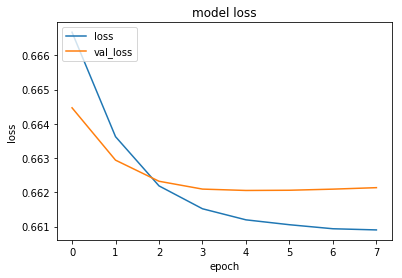

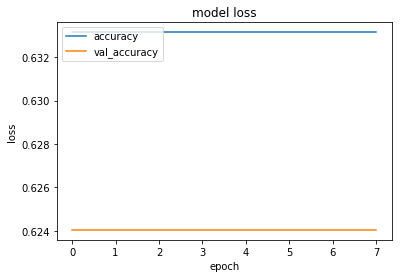

====================== 9 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6678 - acc: 0.6327 - val_loss: 0.6780 - val_acc: 0.6231
Epoch 2/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6663 - acc: 0.6327 - val_loss: 0.6774 - val_acc: 0.6231
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6655 - acc: 0.6327 - val_loss: 0.6772 - val_acc: 0.6231
Epoch 4/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6652 - acc: 0.6327 - val_loss: 0.6771 - val_acc: 0.6231
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6650 - acc: 0.6327 - val_loss: 0.6771 - val_acc: 0.6231
Epoch 6/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6649 - acc: 0.6327 - val_loss: 0.6772 - val_acc: 0.6231
Epoch 7/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6649 - acc: 0.6327 - val_loss: 0

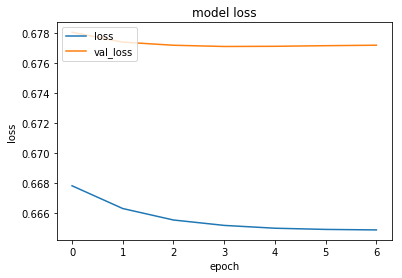

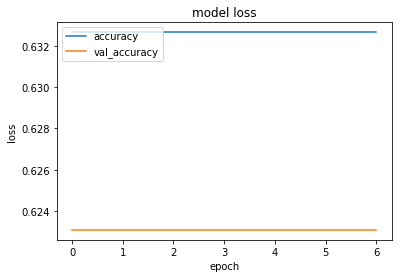

ES STEPS: 1  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 2  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 3  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 4  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 5  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 6  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 7  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 8  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 9  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 10  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 11  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 12  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 13  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 14  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 15  -

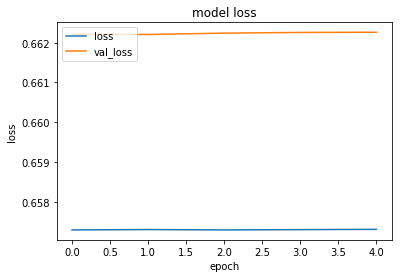

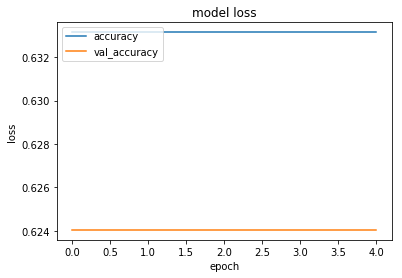

====================== 1 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping


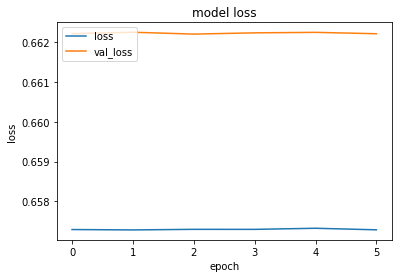

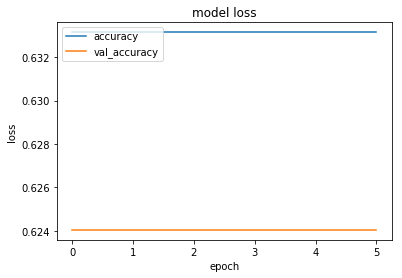

====================== 2 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 78us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


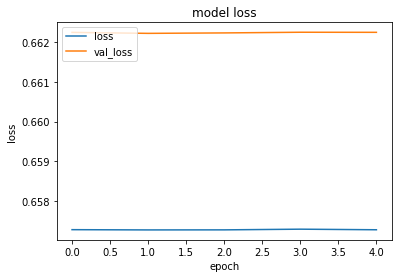

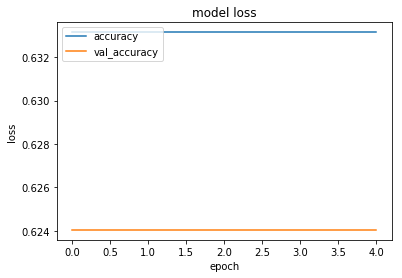

====================== 3 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


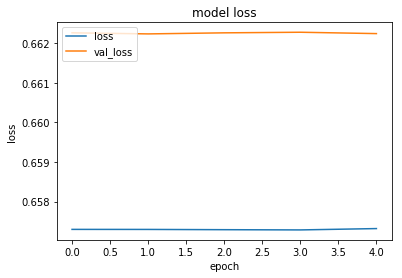

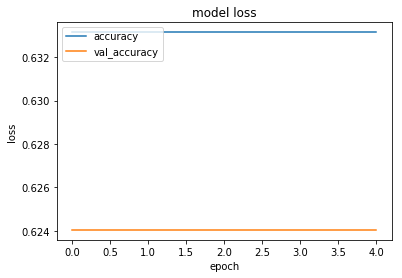

====================== 4 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 78us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping


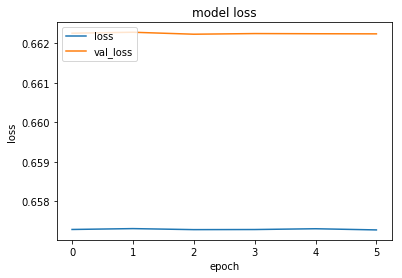

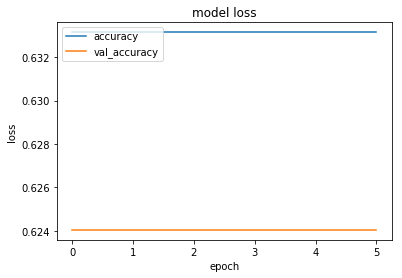

====================== 5 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 78us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


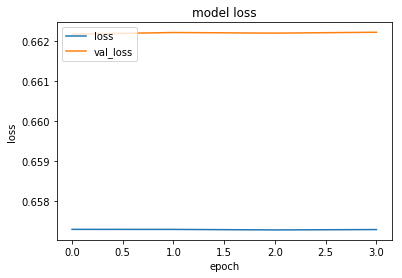

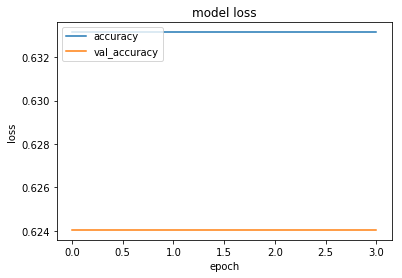

====================== 6 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


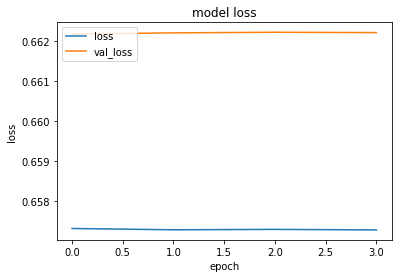

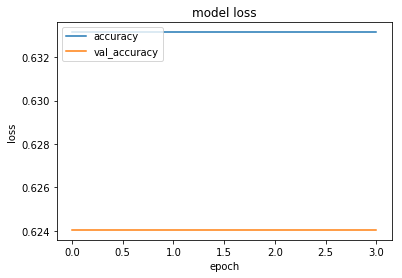

====================== 7 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 7/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0

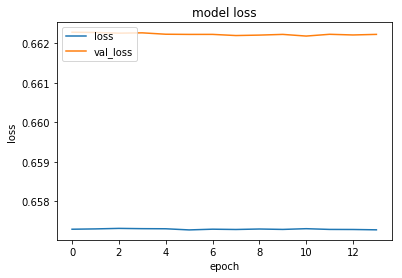

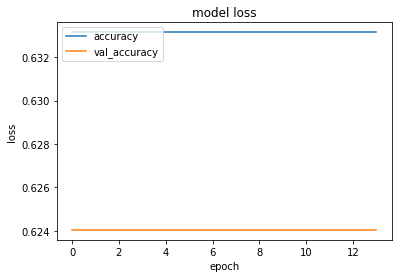

====================== 8 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 78us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 75us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 7/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0

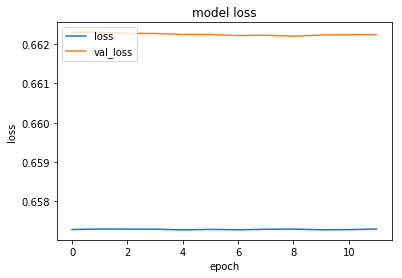

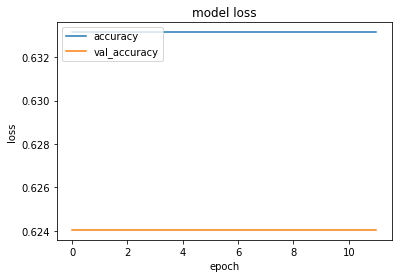

====================== 9 of 10
Train on 4157 samples, validate on 1040 samples
Epoch 1/50
4157/4157 [==============================] - 0s 77us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 2/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 3/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6623 - val_acc: 0.6240
Epoch 4/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 5/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 6/50
4157/4157 [==============================] - 0s 79us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0.6622 - val_acc: 0.6240
Epoch 7/50
4157/4157 [==============================] - 0s 76us/step - loss: 0.6573 - acc: 0.6331 - val_loss: 0

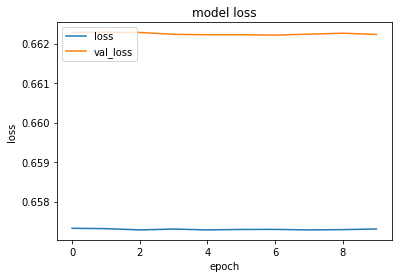

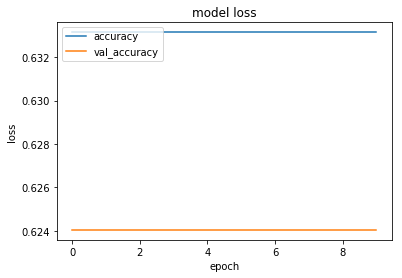

ES STEPS: 1  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 2  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 3  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 4  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 5  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 6  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 7  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 8  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 9  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 10  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 11  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 12  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 13  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 14  - BEST Accuracy: 0.7258  - BEST Score(Log Loss): 0.5368 
ES STEPS: 15  -

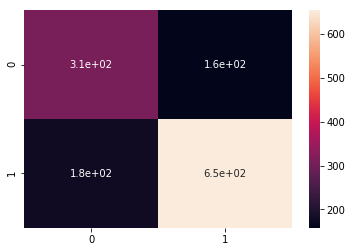

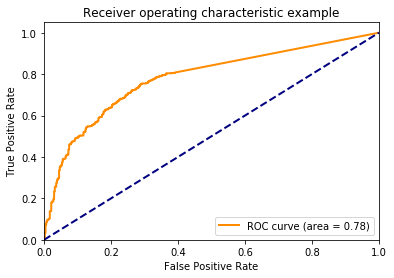

In [26]:
# Initialize
model = ModelCompile()
weights = model.get_weights() 
MyES = ES(model, X_train, y_train, InitialSigma = 0.1, ParentsSize = 15, ChildSize = 100, tao = 0.5)   
weights, ES_Optimized_ObjVal, P_Best10_Weights, P_Best10_Sigma  = MyES.run(weights, useOLSReg =False, max_steps=3, verbose = 1)

# Optimize
GlobalBestAccuracy = 0
NoImproveTimes = 0
while True:
  # Gradient-based Optimize
  for i, i_Weights in enumerate(P_Best10_Weights): 
      print('======================', i, 'of', len(P_Best10_Weights))  
      i_Weights = P_Best10_Weights[i]
      temp_flatten_weight = MyES._UnflattenWeights(WeightsStrucure = MyES.WeightsStrucure, ModifiedWeights = i_Weights)
      model, weights = ModelFit(model=model, weights=temp_flatten_weight, epochs=50)
      _, temp_unflatten_weight = MyES._FlattenWeights(weights) 
      P_Best10_Weights[i] = np.array(temp_unflatten_weight) 
  # ES
  weights, ES_Optimized_ObjVal, P_Best10_Weights, P_Best10_Sigma = MyES.run(weights, max_steps=20, verbose = 1,
                                                                            Population_Parents_Weights=P_Best10_Weights, 
                                                                            Population_Parents_Sigma=P_Best10_Sigma)
  # Stop Criteria
  if ES_Optimized_ObjVal > GlobalBestAccuracy:
    GlobalBestAccuracy = ES_Optimized_ObjVal
    NoImproveTimes = 0
  else: 
    NoImproveTimes = NoImproveTimes + 1
    if NoImproveTimes == 2:
      break
    
model.set_weights(weights)    
Performance(model)

# END